# Import Libraries

In [156]:
import gc, os, warnings, pickle, copy

import pandas as pd
#from pandas.api.types import union_categoricals
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
#import pydot
#import pydotplus

from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet

from datetime import datetime, timedelta
#import pendulum

import math
from itertools import combinations, permutations
from scipy.stats import yeojohnson, jarque_bera, ks_2samp
#from scipy.special import boxcox1p
#from scipy.stats import boxcox
from scipy.sparse import csr_matrix
from scipy import signal

from typing import Union
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
#import ngboost as ngb

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors

from bayes_opt import BayesianOptimization

from tqdm import tqdm

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [157]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [158]:
def plot_feature_importance(feature_importance_df, feature_name='feature', importance_name=['split', 'gain'],
                            top_k=50, fig_width=16, fig_height=8, fontsize=14):
    if isinstance(importance_name, str):
        importance_name = [importance_name]
    
    num_importance = len(importance_name)
    plt.figure(figsize=(fig_width, fig_height*num_importance))
    gs = gridspec.GridSpec(1, num_importance)
    
    def _fetch_best_features(df, fimp='gain'):
        cols = (df[[feature_name, fimp]]
                .groupby(feature_name)
                .mean()
                .sort_values(by=fimp, ascending=False)
                .index
                .values[:top_k])
        return cols, df.loc[df[feature_name].isin(cols)]
    
    for i, fimp in enumerate(importance_name):
        cols, best_features = _fetch_best_features(feature_importance_df, fimp)
        ax = plt.subplot(gs[0, i])
        sns.barplot(x=fimp, y=feature_name, data=best_features, order=cols, ax=ax)
        title = f'Features {fimp} importance (averaged/folds)'
        plt.title(title, fontweight='bold', fontsize=fontsize)
    
    plt.tight_layout()

In [159]:
def neg_checker(submission, inplace=False):
    cols = [_ for _ in submission.columns if 'F' in _]
    temp = submission[cols].columns[(submission[cols] < 0).sum().astype(bool)]
    if temp.any():
        print(f'negative values found in: {temp.tolist()}')
        if inplace:
            submission[cols] = np.where(submission[cols] < 0, 0, submission[cols])
            print('negative values replaced with 0')
            
            temp = submission[cols].columns[(submission[cols] < 0).sum().astype(bool)]
            if temp.any() == False:
                print('no negative values in forecast')
    else:
        print('no negative values in forecast')

In [160]:
def return_list(lst):
    lst.remove('evaluation')
    lst.append('validation')
    return lst

In [161]:
def make_submission(df, submission, in_type):
    
    if in_type == 'public':
        test_df = df[df.type == in_type]
    
        preds = test_df[["id", "date", "sales"]]
        preds = preds.pivot(index="id", columns="date", values="sales").reset_index()
        preds.columns = ["id"] + ["F" + str(d + 1) for d in range(28)]

        evals = submission[submission["id"].str.endswith("evaluation")]
        vals = submission[["id"]].merge(preds, how="inner", on="id")
        final = pd.concat([vals, evals])
        assert final["id"].equals(submission["id"])

    elif in_type == 'private':
        public_preds = df[df.type == 'public'][["id", "date", "sales"]]
        public_preds = public_preds.pivot(index="id", columns="date", values="sales").reset_index()
        public_preds.columns = ["id"] + ["F" + str(d + 1) for d in range(28)]
        
        private_preds = df[df.type == 'private'][["id", "date", "sales"]]
        private_preds = private_preds.pivot(index="id", columns="date", values="sales").reset_index()
        private_preds.columns = ["id"] + ["F" + str(d + 1) for d in range(28)]
        
        final = pd.concat([public_preds, private_preds], axis=0).reset_index(drop=True)
        assert set(submission['id']) == set(final['id'])
    
    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    
    neg_checker(final, inplace=True)

    return final

# Merge and Melt DataFrame

In [162]:
CAL_DTYPES={"event_name_1": "category",
            "event_name_2": "category",
            "event_type_1": "category",
            "event_type_2": "category",
            "weekday": "category",
            'wm_yr_wk': 'int16',
            "wday": "int16",
            "month": "int16",
            "year": "int16",
            "snap_CA": "float32",
            'snap_TX': 'float32',
            'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category",
                "item_id": "category",
                "wm_yr_wk": "int16",
                "sell_price":"float32"}

In [163]:
h = 28
max_lags = 57
tr_last = 1941
fday = datetime(2016, 4, 25)

In [164]:
def create_dt(is_train=True, evaluation=True, nrows=None, first_day=1200):
    prices = pd.read_csv("data/sell_prices.csv", dtype=PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            pass
            # prices[col] = prices[col].cat.codes.astype("int16")
            # prices[col] -= prices[col].min()
            
    cal = pd.read_csv("data/calendar.csv", dtype=CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            pass
            # cal[col] = cal[col].cat.codes.astype("int16")
            # cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    dtype = {numcol:"float32" for numcol in numcols} 
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("data/sales_train_evaluation.csv", 
                     nrows=nrows, usecols=catcols+numcols, dtype=dtype)
    
    for col in catcols:
        if col != "id":
            pass
            # dt[col] = dt[col].cat.codes.astype("int16")
            # dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+28+28+1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                 id_vars=catcols,
                 value_vars=[col for col in dt.columns if col.startswith("d_")],
                 var_name="d",
                 value_name="sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy=False)
    
    return dt

# Utility

In [165]:
seed = 8982
bad_zero_idx = pd.read_csv('data/bad_zero_idxs/bad_zero_idx_287.csv')['0'].values

## Validation Scheme

In [166]:
# n_split = 2 when training final model
# n_split = 4 to validate

In [167]:
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913 (train)
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

In [411]:
class TimeSeriesSplitter:
    def __init__(self, n_splits):
        #if n_splits > 3:
        #    raise NotImplementedError
        self.n_splits = n_splits
        #if use_public:
        #    self.valid_end = datetime(2016,5,22)
        #else:
        #self.valid_end = datetime(2016,4,24)
        self.valid_end = datetime(2016,5,22)
        self.train_end = self.valid_end - timedelta(days=28)
        
    """Manual Coding of folds"""
    def _manual_split(self, data):
        # fold 0
        train_idx_0 = data[(data.date > '2014-01-31') & (data.date <= '2016-01-31')].index #730days
        valid_idx_0 = data[(data.date > '2016-01-31') & (data.date <= '2016-02-28')].index #28days
        # fold 1
        train_idx_1 = data[(data.date >= '2014-03-01') & (data.date <= '2016-02-28')].index #730days
        valid_idx_1 = data[(data.date > '2016-02-28') & (data.date <= '2016-03-27')].index #28days
        # fold 2
        train_idx_2 = data[(data.date >= '2014-03-29') & (data.date <= '2016-03-27')].index #730days
        valid_idx_2 = data[(data.date > '2016-03-27') & (data.date <= '2016-04-24')].index #28days
                    
        idx = [(train_idx_0, valid_idx_0), (train_idx_1, valid_idx_1), (train_idx_2, valid_idx_2)]
        return idx[-self.n_splits:]
    
    """Automatic config of fold indices"""
    def _auto_split(self, data):
        idx = []
        for i in range(self.n_splits):
            i += 1
            fold_train_start = self.train_end - timedelta(days=28*(i-1)) - timedelta(days=730)
            fold_train_end   = self.train_end - timedelta(days=28*(i-1))
            fold_valid_start = self.valid_end - timedelta(days=28*i)
            fold_valid_end   = self.valid_end - timedelta(days=28*(i-1))
            
            idx.append(
                (
                    data[(data.date > str(fold_train_start).split(' ')[0]) & (data.date <= str(fold_train_end).split(' ')[0])].index,
                    data[(data.date > str(fold_valid_start).split(' ')[0]) & (data.date <= str(fold_valid_end).split(' ')[0])].index
                )
            )
        return idx[::-1]
    
    @staticmethod
    def _return_valid_span(end_offset, span):
        valid_end = datetime(2016, 4, 24) - timedelta(days=int(end_offset))
        valid_start = valid_end - timedelta(days=int(span))
        train_end = copy.deepcopy(valid_start)
        train_start = train_end - timedelta(days=730)
        to_str = lambda x: str(x).split(' ')[0]
        valid_start = to_str(valid_start)
        valid_end = to_str(valid_end)
        train_start = to_str(train_start)
        train_end = to_str(train_end)
        return train_start, train_end, valid_start, valid_end
    
    """After evaluation with KS-test"""
    def split(self, data):
        if self.n_splits > 4:
            raise NotImplementedError()
            
        # fold 0
        # ('2013-03-30', '2015-03-30', '2015-03-30', '2015-04-27')
        train_start, train_end, valid_start, valid_end = TimeSeriesSplitter._return_valid_span(363, 28)
        train_idx_0 = data[(data.date > train_start) & (data.date <= train_end)].index #730days
        valid_idx_0 = data[(data.date > valid_start) & (data.date <= valid_end)].index #28days
        
        # fold 1
        # ('2013-10-16', '2015-10-16', '2015-10-16', '2015-11-13')
        train_start, train_end, valid_start, valid_end = TimeSeriesSplitter._return_valid_span(163, 28)
        train_idx_1 = data[(data.date > train_start) & (data.date <= train_end)].index #730days
        valid_idx_1 = data[(data.date > valid_start) & (data.date <= valid_end)].index #28days
        
        # fold 2
        # ('2014-01-29', '2016-01-29', '2016-01-29', '2016-02-26')
        train_start, train_end, valid_start, valid_end = TimeSeriesSplitter._return_valid_span(58, 28)
        train_idx_2 = data[(data.date > train_start) & (data.date <= train_end)].index #730days
        valid_idx_2 = data[(data.date > valid_start) & (data.date <= valid_end)].index #28days
        
        # fold 3
        # ('2014-03-26', '2016-03-25', '2016-03-25', '2016-04-22')
        train_start, train_end, valid_start, valid_end = TimeSeriesSplitter._return_valid_span(2, 28)
        train_idx_3 = data[(data.date > train_start) & (data.date <= train_end)].index #730days
        valid_idx_3 = data[(data.date > valid_start) & (data.date <= valid_end)].index #28days
                    
        idx = [(train_idx_0, valid_idx_0), (train_idx_1, valid_idx_1), (train_idx_2, valid_idx_2), (train_idx_3, valid_idx_3)]
        return idx[-self.n_splits:]
        
    def n_splits(self):
        return int(self.n_splits)

## Logger

In [15]:
df_columns = ['R', 'train_rmse', 'valid_rmse', 'features', 'valid_scheme', 'n_splits', 'description', 'public']

In [16]:
class ExperimentalLogger:
    def __init__(self, DIR=''):
        self.DIR = DIR
    
    def initialize(self, columns=df_columns):
        self.log_df = pd.DataFrame(columns=columns)
        ExperimentalLogger.export(self)
    
    def load(self, ignore_heavy=False):
        log_df = pd.DataFrame()
        cols = os.listdir(self.DIR)
        if '.ipynb_checkpoints' in cols:
            cols.remove('.ipynb_checkpoints')
        subject_col = []
        if ignore_heavy:
            for col in cols:
                if 'model' in col or 'fimp' in col:
                    subject_col.append(col)
        for col in cols:
            if col in subject_col:
                continue
            log_df[col] = pickle.load(open(f'{self.DIR}/{col}', 'rb'))
        self.log_df = log_df
        return self.log_df.copy()
    
    def diff_check(self, log_df, exception_cols=['fimp', 'model', 'models'], print_length=1000): 
        n = set(self.log_df.index.to_list()).intersection(log_df.index.to_list())
        updated = list(set(log_df.index) - n)
        deleted = list(set(self.log_df.index) - n)
        
        if any(updated):
            if type(self.log_df) == type(log_df) == pd.DataFrame:
                print(f'New rows: {updated}')
            elif type(self.log_df) == type(log_df) == pd.Series:
                print(f'New cols: {updated}')
        if any(deleted):
            if type(self.log_df) == type(log_df) == pd.DataFrame:
                print(f'Deleted rows: {deleted}')
            elif type(self.log_df) == type(log_df) == pd.Series:
                print(f'Deleted cols: {deleted}')
        
        # mask = (log_df.iloc[n] != self.log_df.iloc[n])
        for idx in list(n):
            #idx_mask = (log_df.loc[idx] != new_log_df.loc[idx])
            idx_log_df = self.log_df.loc[idx]#[idx_mask]
            idx_new_log_df = log_df.loc[idx]#[idx_mask]
            assert set(idx_log_df.index) == set(idx_new_log_df.index)
            for col in idx_log_df.index:
                
                # (.) skip specified cols
                if col in exception_cols:
                    continue
                
                old_item = idx_log_df[col]
                new_item = idx_new_log_df[col]
                
                # (.) if colitem is list
                if isinstance(old_item, list) or isinstance(new_item, list):
                    if set(old_item) != set(new_item):
                        list_intersection = set(new_item).intersection(old_item)
                        updated = list(set(new_item) - list_intersection)
                        deleted = list(set(old_item) - list_intersection)
                        print(f"Updated value @ [#{idx}, '{col}']: {str(updated)[:print_length]}")
                        print(f"Deleted value @ [#{idx}, '{col}']: {str(deleted)[:print_length]}")
                    continue
                
                if old_item != new_item:
                    try:
                        # (.) if colitem is NaN
                        if np.isnan(old_item) and np.isnan(new_item):
                            continue
                        else:
                            print(f"Updated value @ [#{idx}, '{col}']: {str(old_item)[:print_length]} -> {str(new_item)[:print_length]}")
                    # (.) if passing to np.isnan leads to error
                    except:
                        print(f"Updated value @ [#{idx}, '{col}']: {str(old_item)[:print_length]} -> {str(new_item)[:print_length]}") 
    
    def set_self(self, log_df, backup=False):
        if backup:
            self.prev_log_df = self.log_df.copy()
        self.log_df = log_df 
    
    def return_prev(self):
        return self.prev_log_df.copy()
        
    def export(self):
        for col in self.log_df:
            pickle.dump(self.log_df[col], open(f'{self.DIR}/{col}', 'wb'))
    
    def _eval_input(self):
        print('y/n:')
        self.user_input = input()
        if self.user_input == 'y' or self.user_input == 'n':
            None
        else:
            ExperimentalLogger._eval_input(self)
    
    def record(self, record_dict):
        check_new = set(record_dict.keys()) - set(self.log_df.columns.to_list())
        try:
            assert check_new == set()
            self.log_df = self.log_df.append(record_dict, ignore_index=True)
        except:
            print(f'New column found in recording/appending dict: {list(check_new)}')
            print('Include new column?')
            ExperimentalLogger._eval_input(self)
            if self.user_input == 'y':
                pass
            elif self.user_input == 'n':
                for _ in list(check_new):
                    del record_dict[_]
                print('excluded new columns')
            self.log_df = self.log_df.append(record_dict, ignore_index=True)
        return self.log_df.copy()
    
    def return_log(self):
        return self.log_df.copy()

In [17]:
el = ExperimentalLogger(DIR='log_df')
#el.initialize()
el.load(ignore_heavy=True).tail()

,description,features,n_splits,public,R,train_rmse,valid_rmse
268,i264 XGBoost mock,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,NaN
269,i264 XGBoost,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,2.036928
270,i264 XGBoost,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,0.64802,38,NaN,2.036928
271,5 runs,"[dept_id, store_id, cat_id, state_id, wday, ye...",4,NaN,38,2.102674,2.039951
272,5 runs XGBoost,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",4,NaN,38,NaN,2.066335


In [18]:
del df_columns; gc.collect()

42

# Features

## Feature Engineering

In [378]:
def create_fea(dt):
    
    """sales (target) lag"""
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)
    dt['lag_14'] = dt[['id', 'sales']].groupby('id')['sales'].shift(14)
    
    """sales (target) lag rolling mean"""
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rolling_mean_l{lag}_w{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
            dt[f"rolling_std_l{lag}_w{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std())
    
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
        #"ime": "is_month_end",
        #"ims": "is_month_start",
    }
    
    #dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace=True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            #print(date_feat_name)
            dt[date_feat_name] = dt[date_feat_name].astype(np.int16)
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype(np.int16)

In [20]:
def non_recursive_fe(df):
    """price features"""
    temp = df.groupby(['store_id', 'item_id']).sell_price
    #df['price_max'] = temp.transform('max')
    #df['price_min'] = temp.transform('min')
    #df['price_std'] = temp.transform('std')
    df['price_mean'] = temp.transform('mean')
    #f['price_nunique'] = temp.transform('nunique')
    #f['price_norm'] = df['sell_price'] / df['price_max']
    #f['price_log1p'] = df.sell_price.apply(np.log1p)
    #f['price_momentum_day'] = df['sell_price'] / temp.transform(lambda x: x.shift(1))
    df['price_momentum_month'] = df['sell_price'] / df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
    #df['price_momentum_year'] = df['sell_price'] / df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')
    
    """item_id features"""
    #df['item_nunique'] = df.groupby(['store_id', 'sell_price']).item_id.transform('nunique')

In [21]:
def target_encoder(train, cv, subject_cols, train_source_idx, statistic, print_option=True):
    
    """concatenate categories"""
    train['temp'] = 'concat'
    for _ in subject_cols:
        train['temp'] += '_' + train[_].astype(str)
    train['temp'] = train.temp.astype('category')
    
    """define new col name"""
    col_name = 'te'
    for col in subject_cols:
        col_name += f'_{col}'
    
    if not any(cv):
        grid = train.loc[train_source_idx].groupby('temp').sales.describe()
        for _ in statistic:
            assert _ in grid.columns, print(f'{_} not in pd.DataFrame().describe()')
            train[f'{col_name}_{_}'] = train.temp.map(grid[_]).astype(np.float32)
        # gc.collect()
        
        grid = train.loc[train_source_idx].groupby('temp').sales.quantile(0.88)
        train[f'{col_name}_q88'] = train.temp.map(grid).astype(np.float32)
        
        _ = [_ for _ in train.columns if col_name in _]
        #assert train[_].isna().sum().sum() == 0, print(_)
    else:
        assert len(cv) == 1
        for valid_scheme in cv:
            #train_idxs = set()
            for train_idx, valid_idx in valid_scheme.split(train.loc[train_source_idx], train.sales.loc[train_source_idx]):
                print('.', end='')
                train_idx = train.loc[train_source_idx].iloc[train_idx].index
                valid_idx = train.loc[train_source_idx].iloc[valid_idx].index
                grid = train.loc[train_idx].groupby('temp').sales.describe()
                for _ in statistic:
                    assert _ in grid.columns, print(f'{_} not in pd.DataFrame.describe')
                    train.loc[valid_idx, f'{col_name}_{_}'] = train.temp.map(grid[_]).astype(np.float32)
                gc.collect()
                
                grid = train.loc[train_idx].groupby('temp').sales.quantile(0.88)
                train.loc[valid_idx, f'{col_name}_q88'] = train.temp.map(grid).astype(np.float32)

                _ = [_ for _ in train.columns if col_name in _]
                assert train[_].loc[valid_idx].isna().sum().sum() == 0, print(_)

                #for _ in train_idx:
                #    train_idxs.add(_)
    
    #grid = train.iloc[list(train_idxs)].groupby('temp').sales.describe()
    #grid = train.loc[train_source_idx].groupby('temp').sales.describe()
    #for _ in statistic:
    #    test[f'{col_name}_{_}'] = test.temp.map(grid[_])
    
    #grid = train.iloc[list(train_idxs)].groupby('temp').sales.quantile(0.88)
    #grid = train.loc[train_source_idx].groupby('temp').sales.quantile(0.88)
    #test[f'{col_name}_q88'] = test['temp'].map(grid)
    
    #_ = [_ for _ in train.columns if col_name in _]
    #assert test[_].isna().sum().sum() == 0
    
    if print_option:
        print(f"'{col_name}_q88',")
        for _ in statistic:
            print(f"'{col_name}_{_}',")
    
    del grid, _
    train.drop(columns=['temp'], inplace=True)
    #test.drop(columns=['temp'], inplace=True)
    gc.collect()

In [22]:
def apply_cyclical(df, str_col, print_option=True):
    # e.g. df['hr'] = df.timestamp.dt.hour; apply_cyclical(df, 'hr')
    # ===== assumes integer array =====
    # ===== assumes min and max exists in array =====
    temp = pd.DataFrame()
    temp['unique_sorted'] = (df[str_col] - df[str_col].min()).sort_values().unique()
    int_max = temp.unique_sorted.max()
    temp['sin'] = np.sin(2 * np.pi * temp.unique_sorted / int_max)
    temp['cos'] = np.cos(2 * np.pi * temp.unique_sorted / int_max)
    temp = temp.set_index('unique_sorted')
    df[f'{str_col}_sin'] = (df[str_col] - df[str_col].min()).map(temp.sin)
    df[f'{str_col}_cos'] = (df[str_col] - df[str_col].min()).map(temp.cos)
    
    if print_option:
        print(f"'{str_col}_sin', '{str_col}_cos',")
    del temp, int_max; gc.collect()

In [170]:
df = create_dt(is_train=True, first_day=350)
test_df_temp = create_dt(False)
test_df_temp = test_df_temp[test_df_temp.date >= '2016-05-23']
df = pd.concat([df, test_df_temp], axis=0).reset_index(drop=True)
del test_df_temp; gc.collect()

0

In [171]:
for _ in [_ for _ in df.columns if 'event'in _]:
    df[_] = df[_].cat.add_categories('no_event')
    df[_] = df[_].fillna('no_event')
    df[_] = df[_].astype('category').cat.codes.astype('category')

In [172]:
df.loc[(df.date <= '2016-04-24'), 'type'] = 'train'
df.loc[(df.date >= '2016-04-25') & (df.date <= '2016-05-22'), 'type'] = 'public'
df.loc[(df.date >= '2016-05-23'), 'type'] = 'private'

In [173]:
create_fea(df)
df['year'] = df.year.astype('category')

wday
month
year


In [174]:
non_recursive_fe(df)

In [175]:
target_encoder(df, [], ['wday', 'store_id', 'item_id'],
               df[(df.type == 'train')].index, ['count', 'mean', 'std', 'max'])

'te_wday_store_id_item_id_q88',
'te_wday_store_id_item_id_count',
'te_wday_store_id_item_id_mean',
'te_wday_store_id_item_id_std',
'te_wday_store_id_item_id_max',


In [176]:
target_encoder(df, [], ['mday', 'store_id', 'item_id'],
               df[(df.type == 'train')].index, ['count', 'mean', 'std', 'max'])

'te_mday_store_id_item_id_q88',
'te_mday_store_id_item_id_count',
'te_mday_store_id_item_id_mean',
'te_mday_store_id_item_id_std',
'te_mday_store_id_item_id_max',


In [177]:
# target_encoder(df, [], ['week', 'store_id', 'item_id'],
#                df[(df.type == 'train')].index, ['count', 'mean', 'std', 'max'])

In [178]:
# target_encoder(df, [], ['month', 'store_id', 'item_id'],
#                df[(df.type == 'train')].index, ['count', 'mean', 'std', 'max'])

In [179]:
for _ in ['wday', 'week', 'mday', 'month']:
    apply_cyclical(df, _)

'wday_sin', 'wday_cos',
'week_sin', 'week_cos',
'mday_sin', 'mday_cos',
'month_sin', 'month_cos',


In [180]:
def apply_price_decomposition(df, str_col, print_option=True):
    modify = np.vectorize(math.modf)
    
    after_decimal, before_decimal = modify(df[str_col])
    after_tenth, before_tenth = modify(df[str_col] / 10)
    after_hunth, before_hunth = modify(df[str_col] / 100)
    
    at_oneth = df[str_col].astype(str).apply(lambda x: x.split('.')[0][-1])
    at_tenth = (df[str_col] / 10).astype(str).apply(lambda x: x.split('.')[0][-1])
    at_hunth = (df[str_col] / 100).astype(str).apply(lambda x: x.split('.')[0][-1])
    
    for _ in ['after', 'before']:
        for __ in ['decimal', 'tenth', 'hunth']:
            df[f'{str_col}_{_}_{__}'] = eval(f'{_}_{__}')
            if print_option:
                print(f"'{str_col}_{_}_{__}',")
    
    for _ in ['oneth', 'tenth', 'hunth']:
        df[f'{str_col}_at_{_}'] = eval(f'at_{_}')
        if print_option:
            print(f"'{str_col}_at_{_}',")

In [181]:
for _ in ['sell_price']:#, 'price_mean', 'price_momentum_month']:
    apply_price_decomposition(df, _)

'sell_price_after_decimal',
'sell_price_after_tenth',
'sell_price_after_hunth',
'sell_price_before_decimal',
'sell_price_before_tenth',
'sell_price_before_hunth',
'sell_price_at_oneth',
'sell_price_at_tenth',
'sell_price_at_hunth',


In [35]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [36]:
print(model.most_similar(positive=['Hobbies', 'monday'], negative=[], topn=3))

[('sunday', 0.5407546758651733), ('saturday', 0.5406692028045654), ('wednesday', 0.5385640859603882)]


In [37]:
def word2vec_fe(df, model, dim_start_end):
    
    def _return_dict(cols, consider_lower):
        dict_df = pd.DataFrame()
        #cols = df[col].unique()
        
        for upper in cols:
            
            if consider_lower:
                lower = upper.lower()
                _ = (model[upper] + model[lower]) / 2
            else:
                _ = model[upper]
            
            temp = pd.DataFrame(_.reshape(1,-1))
            temp.rename(columns={_: f'word2vec_{_}' for _ in temp.columns}, inplace=True)
            dict_df = pd.concat([dict_df, temp], axis=0)
            
            del temp, _; gc.collect()
        
        if 'Hobbies' in cols:
            cols = list(map(str.upper, cols))
        
        dict_df.index = cols
        return dict_df.reset_index()
    
    weekday = df.weekday.unique()
    dict_df = _return_dict(weekday, True)
    cat_id = ['Hobbies', 'Household', 'Foods']
    dict_df = pd.concat([dict_df, _return_dict(cat_id, True)], axis=0)
    #state_id = ['California', 'Texas', 'Wisconsin']
    #dict_df = pd.concat([dict_df, _return_dict(state_id, True)], axis=0)
    dict_df = dict_df.set_index('index')
    
    start_dim, end_dim = dim_start_end
    word2vec_cols = [_ for _ in dict_df.columns if 'word2vec' in _][start_dim:end_dim]
    for _ in word2vec_cols:
        df[_] = np.nan
    
    for _ in df.weekday.unique():
        for __ in df.cat_id.unique():
            for ___ in word2vec_cols:
                df.loc[(df.weekday == _) & (df.cat_id == __), ___] = dict_df.loc[_][___] + dict_df.loc[__][___]
    
    del _, __, weekday, cat_id, word2vec_cols; gc.collect()
    return dict_df

In [182]:
%%time
word2vec_fe(df, model, (0, 5))

Wall time: 1min 8s


,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,word2vec_10,word2vec_11,word2vec_12,word2vec_13,word2vec_14,word2vec_15,word2vec_16,word2vec_17,word2vec_18,word2vec_19,word2vec_20,word2vec_21,word2vec_22,word2vec_23,word2vec_24,word2vec_25,word2vec_26,word2vec_27,word2vec_28,word2vec_29,word2vec_30,word2vec_31,word2vec_32,word2vec_33,word2vec_34,word2vec_35,word2vec_36,word2vec_37,word2vec_38,word2vec_39,word2vec_40,word2vec_41,word2vec_42,word2vec_43,word2vec_44,word2vec_45,word2vec_46,word2vec_47,word2vec_48,word2vec_49,word2vec_50,word2vec_51,word2vec_52,word2vec_53,word2vec_54,word2vec_55,word2vec_56,word2vec_57,word2vec_58,word2vec_59,word2vec_60,word2vec_61,word2vec_62,word2vec_63,word2vec_64,word2vec_65,word2vec_66,word2vec_67,word2vec_68,word2vec_69,word2vec_70,word2vec_71,word2vec_72,word2vec_73,word2vec_74,word2vec_75,word2vec_76,word2vec_77,word2vec_78,word2vec_79,word2vec_80,word2vec_81,word2vec_82,word2vec_83,word2vec_84,word2vec_85,word2vec_86,word2vec_87,word2vec_88,word2vec_89,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99,word2vec_100,word2vec_101,word2vec_102,word2vec_103,word2vec_104,word2vec_105,word2vec_106,word2vec_107,word2vec_108,word2vec_109,word2vec_110,word2vec_111,word2vec_112,word2vec_113,word2vec_114,word2vec_115,word2vec_116,word2vec_117,word2vec_118,word2vec_119,word2vec_120,word2vec_121,word2vec_122,word2vec_123,word2vec_124,word2vec_125,word2vec_126,word2vec_127,word2vec_128,word2vec_129,word2vec_130,word2vec_131,word2vec_132,word2vec_133,word2vec_134,word2vec_135,word2vec_136,word2vec_137,word2vec_138,word2vec_139,word2vec_140,word2vec_141,word2vec_142,word2vec_143,word2vec_144,word2vec_145,word2vec_146,word2vec_147,word2vec_148,word2vec_149,word2vec_150,word2vec_151,word2vec_152,word2vec_153,word2vec_154,word2vec_155,word2vec_156,word2vec_157,word2vec_158,word2vec_159,word2vec_160,word2vec_161,word2vec_162,word2vec_163,word2vec_164,word2vec_165,word2vec_166,word2vec_167,word2vec_168,word2vec_169,word2vec_170,word2vec_171,word2vec_172,word2vec_173,word2vec_174,word2vec_175,word2vec_176,word2vec_177,word2vec_178,word2vec_179,word2vec_180,word2vec_181,word2vec_182,word2vec_183,word2vec_184,word2vec_185,word2vec_186,word2vec_187,word2vec_188,word2vec_189,word2vec_190,word2vec_191,word2vec_192,word2vec_193,word2vec_194,word2vec_195,word2vec_196,word2vec_197,word2vec_198,word2vec_199,word2vec_200,word2vec_201,word2vec_202,word2vec_203,word2vec_204,word2vec_205,word2vec_206,word2vec_207,word2vec_208,word2vec_209,word2vec_210,word2vec_211,word2vec_212,word2vec_213,word2vec_214,word2vec_215,word2vec_216,word2vec_217,word2vec_218,word2vec_219,word2vec_220,word2vec_221,word2vec_222,word2vec_223,word2vec_224,word2vec_225,word2vec_226,word2vec_227,word2vec_228,word2vec_229,word2vec_230,word2vec_231,word2vec_232,word2vec_233,word2vec_234,word2vec_235,word2vec_236,word2vec_237,word2vec_238,word2vec_239,word2vec_240,word2vec_241,word2vec_242,word2vec_243,word2vec_244,word2vec_245,word2vec_246,word2vec_247,word2vec_248,word2vec_249,word2vec_250,word2vec_251,word2vec_252,word2vec_253,word2vec_254,word2vec_255,word2vec_256,word2vec_257,word2vec_258,word2vec_259,word2vec_260,word2vec_261,word2vec_262,word2vec_263,word2vec_264,word2vec_265,word2vec_266,word2vec_267,word2vec_268,word2vec_269,word2vec_270,word2vec_271,word2vec_272,word2vec_273,word2vec_274,word2vec_275,word2vec_276,word2vec_277,word2vec_278,word2vec_279,word2vec_280,word2vec_281,word2vec_282,word2vec_283,word2vec_284,word2vec_285,word2vec_286,word2vec_287,word2vec_288,word2vec_289,word2vec_290,word2vec_291,word2vec_292,word2vec_293,word2vec_294,word2vec_295,word2vec_296,word2vec_297,word2vec_298,word2vec_299
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [183]:
df.groupby(['wday', 'cat_id']).word2vec_0.unique()

wday  cat_id   
1     HOBBIES            [0.193115234375]
      HOUSEHOLD          [0.010009765625]
      FOODS             [-0.106689453125]
2     HOBBIES            [0.227294921875]
      HOUSEHOLD          [0.044189453125]
      FOODS             [-0.072509765625]
3     HOBBIES           [0.1461181640625]
      HOUSEHOLD        [-0.0369873046875]
      FOODS            [-0.1536865234375]
4     HOBBIES            [0.121826171875]
      HOUSEHOLD         [-0.061279296875]
      FOODS             [-0.177978515625]
5     HOBBIES       [0.21598052978515625]
      HOUSEHOLD     [0.03287506103515625]
      FOODS        [-0.08382415771484375]
6     HOBBIES          [0.05535888671875]
      HOUSEHOLD       [-0.12774658203125]
      FOODS           [-0.24444580078125]
7     HOBBIES            [0.067626953125]
      HOUSEHOLD         [-0.115478515625]
      FOODS             [-0.232177734375]
Name: word2vec_0, dtype: object

## Feature Management

In [40]:
def return_cols(df, separate_cat=False):
    
    if not separate_cat:
        train_cols = [#'item_id',
                      'dept_id', 'store_id', 'cat_id', 'state_id',

                      'wday', #'month',
                      'year', 'week', 'quarter', 'mday',

                      'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',

                      'sell_price',

                      'lag_7', 'lag_28',

                      'rolling_mean_l7_w7', 'rolling_mean_l28_w7', 'rolling_mean_l7_w28', 'rolling_mean_l28_w28',
                      'rolling_std_l7_w7', #'rolling_std_l28_w7', #'rolling_std_l7_w28', 'rolling_std_l28_w28'

                      #'price_max', 'price_min', 'price_std',
                      'price_mean',
                      #'price_nunique', 'price_norm', 'price_log1p', 'price_momentum_day',
                      'price_momentum_month', #'price_momentum_year', 'item_nunique',

                      'word2vec_0', 'word2vec_1',

                      'te_wday_store_id_item_id_q88', 'te_wday_store_id_item_id_count',

                      'te_mday_store_id_item_id_q88', 'te_mday_store_id_item_id_count',
                      'te_mday_store_id_item_id_mean', 'te_mday_store_id_item_id_max',

                      #'te_week_store_id_item_id_mean', 'te_week_store_id_item_id_std', 'te_week_store_id_item_id_max',
                      #'te_month_store_id_item_id_mean',

                      'lag_14', 

                      #'rolling_std_l28_w35',
                      'wday_sin', 'wday_cos', 'sell_price_before_decimal',

                     ]

        #train_cols = df.columns[~df.columns.isin(useless_cols)].tolist()

        df[train_cols]
        return train_cols

    else:
        num_cols = ['wday', 'week', 'quarter', 'mday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28',
                    'rolling_mean_l7_w7', 'rolling_mean_l28_w7', 'rolling_mean_l7_w28', 'rolling_mean_l28_w28', 'rolling_std_l7_w7',
                    'price_mean', 'price_momentum_month', 'word2vec_0', 'word2vec_1', 'te_wday_store_id_item_id_q88',
                    'te_wday_store_id_item_id_count', 'te_mday_store_id_item_id_q88', 'te_mday_store_id_item_id_count',
                    'te_mday_store_id_item_id_mean', 'te_mday_store_id_item_id_max', 'lag_14', 'wday_sin', 'wday_cos',
                    'sell_price_before_decimal',
            ]
        cat_cols = ['dept_id', 'store_id', 'cat_id', 'state_id', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
            ]
        return num_cols, cat_cols

# LightGBM Regressor (RMSE)

In [41]:
# weights = pd.read_csv('data/wrmsse_weights.csv')
# weight1 = weights.weights1.values
# weight2 = weights.weights2.values
# NUM_ITEMS = 30490

In [405]:
class MyLgb:
    def __init__(self,
                 target_col, feature_cols, seed,
                 metric=['rmse'], train_metric=None, eval_metric=None,
                 num_leaves=128, learning_rate=0.075, feature_fraction=0.8, bagging_fraction=0.75,
                 lambda_l1=0.0, lambda_l2=0.0, min_data_in_leaf=100, min_child_weight=1e-3,
                 tweedie_variance_power=1.5):
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.metric = metric
        self.train_metric = train_metric
        self.eval_metric = eval_metric
        self.names = ['train_set', 'valid_set']
        self.params = {
            'boosting': 'gbdt', 'objective': 'tweedie', 'metric': self.metric,
            'seed': seed, 'n_jobs': -1,
            'num_leaves': int(np.round(num_leaves)), 'learning_rate': learning_rate,
            'feature_fraction': feature_fraction, 'bagging_fraction': bagging_fraction, 'bagging_freq': 1,
            'min_data_in_leaf': int(np.round(min_data_in_leaf)), 'min_child_weight': min_child_weight,
            "force_row_wise": False,
            'tweedie_variance_power': tweedie_variance_power,
            'lambda_l1': lambda_l1, 'lambda_l2': lambda_l2,
        }
        self.train_params = {}
        if self.train_metric:
            self.train_params['fobj'] = self.train_metric._train
        if self.eval_metric:
            self.train_params['feval'] = self.eval_metric._eval
            self.params['metric'] = 'custom'
    
    """printing function for each fold"""
    @staticmethod
    def _print(valid_scheme, fold_i):
        if fold_i == 0:
            print(f'fold ({fold_i+1}/{valid_scheme.n_splits})', end=', ')
        elif fold_i + 1 == valid_scheme.n_splits:
            print(f'({fold_i+1}/{valid_scheme.n_splits})')
        else:
            print(f'({fold_i+1}/{valid_scheme.n_splits})', end=', ')
    
    """feature importance collecting function"""
    def _fimp(self, model, scheme_i, fold_i):
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = self.feature_cols
        fold_importance_df['gain'] = model.feature_importance(importance_type='gain')
        fold_importance_df['split'] = model.feature_importance(importance_type='split')
        fold_importance_df['scheme'] = scheme_i + 1
        fold_importance_df['fold'] = fold_i + 1
        self.fimp = pd.concat([self.fimp, fold_importance_df], axis=0)
        del fold_importance_df; gc.collect()
    
    """returns list of models for test time and fimp_df"""
    def cross_validate(self, train_df: pd.DataFrame, cv: list, logger, what: str, record=True, verbose=200, mock=False):
        #metric_tr = {_: [] for _ in self.metric}
        #metric_cv = {_: [] for _ in self.metric}
        metric_tr = []; metric_cv = []; models = []; learning_curves = []
        self.fimp = pd.DataFrame()
        #valid_idxs = {}
        
        for scheme_i, valid_scheme in enumerate(cv):
            
            """alter seed per valid_scheme"""
            print(f'scheme ({scheme_i+1}/{len(cv)})', end=': ')
            params = self.params.copy()
            params['seed'] = self.params['seed'] + scheme_i
            #valid_idxs[scheme_i] = {}
            train_df[f'lgb_oof_{int(params["seed"])}'] = np.nan
            
            for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme._auto_split(train_df)):
            #for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme.split(train_df)):
                
                MyLgb._print(valid_scheme, fold_i)
                
                #for _ in valid_idx:
                #    valid_idxs[scheme_i].add(_)
                
                if mock:
                    print(f'train: {train_df.date.loc[train_idx].min()} ~ {train_df.date.loc[train_idx].max()}')
                    print(f'valid: {train_df.date.loc[valid_idx].min()} ~ {train_df.date.loc[valid_idx].max()}')
                    continue
                
                #temp = train_df.loc[train_idx].copy()
                #temp['sales'] = np.where(temp.sales > 0, 1, 0)
                
                train_idx = list(set(train_idx) - set(bad_zero_idx))
                
                d_train = lgb.Dataset(train_df[self.feature_cols].loc[train_idx],
                                      label=train_df[self.target_col].loc[train_idx].values)
                                      #categorical_feature=category_cols)
                
                #temp = train_df.loc[valid_idx].copy()
                #temp['sales'] = np.where(temp.sales > 0, 1, 0)
                
                d_valid = lgb.Dataset(train_df[self.feature_cols].loc[valid_idx],
                                      label=train_df[self.target_col].loc[valid_idx].values)
                                      #categorical_feature=category_cols)
                
                # del temp; gc.collect()
                
                learning_curve = {}
                model = lgb.train(params,
                                  train_set=d_train,
                                  valid_sets=[d_train, d_valid],
                                  valid_names=self.names,
                                  num_boost_round=10_000,
                                  early_stopping_rounds=400,
                                  evals_result=learning_curve,
                                  verbose_eval=verbose,
                                  **self.train_params)
                models.append(model)
                learning_curves.append(learning_curve)
                
                train_df.loc[valid_idx, f'lgb_oof_{int(params["seed"])}'] = model.predict(train_df[self.feature_cols].loc[valid_idx],
                                                                                          num_iteration=model.best_iteration)
                assert train_df.loc[valid_idx, f'lgb_oof_{int(params["seed"])}'].isna().sum() == 0
                
                #for _ in self.metric:
                #    metric_tr[_].append(model.best_score[self.names[0]][_])
                #    metric_cv[_].append(model.best_score[self.names[1]][_])
                metric_tr.append(model.best_score[self.names[0]]['rmse'])
                metric_cv.append(model.best_score[self.names[1]]['rmse'])
                
                # print('recording fimp...')
                MyLgb._fimp(self, model, scheme_i, fold_i)
                
                del d_train, d_valid, model, learning_curve
                gc.collect()
        
        """collect oof in time-series setting"""
        # valid_rmse = 0
        # for scheme_i, valid_scheme in enumerate(cv):
        #     total_valid_idx = list(set(valid_idxs[scheme_i]))
        #     oof = np.zeros(len(total_valid_idx))
        #     for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme.split(train_df)):
        #         model = models[fold_i]
        #         oof[valid_idx] = model.predict(train_df[self.feature_cols].loc[valid_idx], num_iteration=model.best_iteration)
        #     valid_rmse += np.sqrt(mean_squared_error(train_df[self.target_col].loc[total_valid_idx], oof))
        # valid_rmse /= (scheme_i + 1)
        # print('total_valid_rmse:', valid_rmse)
        # print('average of folds:', np.mean(metric_cv))
        
        if record:
            record_dict = {'description': what,
                           'features': self.feature_cols.copy(),
                           'n_splits': cv[0].n_splits,
                           'R': len(self.feature_cols),
                           'train_rmse': np.mean(metric_tr),
                           'valid_rmse': np.mean(metric_cv),
                           #'valid_rmse': valid_rmse,
                           #'valid_scheme': cv
                          }
            logger.record(record_dict)
            try:
                logger.export()
            except:
                print('Logger export failed')
        
        gc.collect()
        return models, self.fimp, np.mean(metric_tr), np.mean(metric_cv)

In [43]:
def store_multi_model(df, feature_cols, seed, record, what):
    
    feature_cols = feature_cols.copy()
    for _ in ['store_id', 'state_id']:
        if _ in feature_cols:
            feature_cols.remove(_)
    
    info = pd.DataFrame()
    for _ in df.store_id.unique():
        print(f'store_id {_}', end=': ')
        store_df = df[df.store_id == _].reset_index(drop=True)
        gbm = MyLgb(target_col='sales', feature_cols=feature_cols, seed=seed)#, eval_metric=wrmsse)
        models, fimp, train_score, valid_score = gbm.cross_validate(store_df, [tscv], el, '', record=False, verbose=0, mock=False)
        info = info.append({'store_id': _,
                            'train_score': train_score, 'valid_score': valid_score,
                            'models': models, 'fimp': fimp},
                           ignore_index=True)
    
    if record:
        el.record({'description': what, 'features': feature_cols.copy(), 'R': len(feature_cols), 'n_splits': tscv.n_splits,
                   'train_rmse': np.mean(info.train_score), 'valid_rmse': np.mean(info.valid_score)})
        try:
            el.export()
        except:
            print('Logger export failed')
    return info

In [44]:
def iter_selection(best_idx, train_cols, subject_cols, single_model):
    initial_best_idx = best_idx
    best_info = None
    
    for _ in subject_cols:
        copied_cols = train_cols.copy()
        train_cols.append(_)
        print(f'R({len(train_cols)}) w/ {_}')
        
        if single_model:
            gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed)
            models, fimp, train_score, valid_score = gbm.cross_validate(df, [tscv],
                                                                        el, f'from {initial_best_idx}, testing {_}',
                                                                        record=True, verbose=0, mock=False)
        else:
            info = store_multi_model(df, train_cols, seed, record=True, what=f'from {initial_best_idx}, testing {_}')
        
        best_score = el.return_log().loc[best_idx].valid_rmse
        valid_score = el.return_log().iloc[-1].valid_rmse
        
        if best_score <= valid_score:
            print('did not improve')
            print(f'{best_score} -x {valid_score}')
            train_cols = copied_cols
            # same as train_cols.remove(_)
        
        elif valid_score < best_score:
            print(f'improved: best_idx {best_idx} -> ', end='')
            best_idx = el.return_log().index.tolist()[-1]
            print(best_idx)
            print(f'{best_score} -> {valid_score}')
            
            if single_model:
                best_info = (models, fimp)
            else:
                best_info = info
        
        print()
    
    return best_info, best_idx, train_cols

In [138]:
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=8982)
models, fimp = gbm.cross_validate(df, [tscv], el, 'mock', mock=True)
el.return_log()

scheme (1/1): fold (1/2), (2/2)


,description,features,n_splits,public,R,train_rmse,valid_rmse,valid_scheme
0,mock,"[item_id, dept_id, store_id, cat_id, state_id,...",2,NaN,25,NaN,NaN,[<__main__.TimeSeriesSplitter object at 0x0000...


In [47]:
%%time
# tweedie objective, rmse metric
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [tscv], el, 'new validation scheme', record=True, mock=False)
el.return_log().loc[13:13]

,description,features,n_splits,public,R,train_rmse,valid_rmse
13,new validation scheme,"[item_id, dept_id, store_id, cat_id, state_id,...",4,NaN,25,2.141441,2.079784


In [317]:
el.return_log().loc[best_idx:best_idx]

,description,features,n_splits,public,R,train_rmse,valid_rmse
141,"from 121, testing rolling_std_l28_w35","[item_id, dept_id, store_id, cat_id, state_id,...",4,0.705262,38,2.1017,2.050219


### Automated Feature Elimination (2 Fold)

In [374]:
def iter_elimination(best_idx, subject_cols, single_model):
    initial_best_idx = best_idx
    best_info = None
    
    for _ in subject_cols:
        copied_cols = train_cols.copy()
        train_cols.remove(_)
        print(f'R({len(train_cols)}) w/ removing {_}')
        
        if single_model:
            gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed)
            models, fimp, train_score, valid_score = gbm.cross_validate(df, [tscv],
                                                                        el, f'from {initial_best_idx}, testing {_}',
                                                                        record=True, verbose=0, mock=False)
        else:
            info = store_multi_model(df, train_cols, seed, record=True, what=f'from {initial_best_idx}, testing {_}')
        
        best_score = el.return_log().loc[best_idx].valid_rmse
        valid_score = el.return_log().iloc[-1].valid_rmse
        
        if best_score <= valid_score:
            print('did not improve')
            print(f'{best_score} -x {valid_score}')
            train_cols = copied_cols
        
        elif valid_score < best_score:
            print(f'improved: best_idx {best_idx} -> ', end='')
            best_idx = el.return_log().index.tolist()[-1]
            print(best_idx)
            print(f'{best_score} -> {valid_score}')
            
            if single_model:
                best_info = (models, fimp)
            else:
                best_info = info
        
        print()
    
    return best_info, best_idx

In [596]:
el.return_log().loc[[206, 225]]

,description,features,n_splits,public,R,train_rmse,valid_rmse
206,,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.504157,35,1.974502,2.036935
225,,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.514350,38,1.962593,2.036142


### Simple Data Cleaning

In [189]:
def make_is_bad_zero(_df):
    is_zero = _df.sales == 0
    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    is_bad_mask = ids.map(ids.value_counts()) >= min_interval
    return is_bad_mask

In [194]:
def find_bad_zeros(_df):
    """Returns an Index object containing only the rows which should be deleted."""
    is_bad_zero = _df.groupby(['store_id', 'item_id']).apply(make_is_bad_zero)
    return is_bad_zero[is_bad_zero].index.droplevel([0, 1])

In [157]:
# bad_zero_idx = pd.read_csv('data/bad_zero_idx_93.csv')['0'].values
bad_zero_idx = find_bad_zeros(df)

In [158]:
# pd.Series(bad_zero_idx).to_csv('data/bad_zero_idx_93.csv', index=False)

In [239]:
bad_zero_idx = pd.read_csv('data/bad_zero_idxs/bad_zero_idx_287.csv')['0'].values
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                            el, '(287)-period bad zero removed only in train', record=True, mock=False)

Training until validation scores don't improve for 400 rounds
[200]	train_set's rmse: 2.12623	valid_set's rmse: 2.11412
[400]	train_set's rmse: 2.085	valid_set's rmse: 2.11165
[600]	train_set's rmse: 2.05902	valid_set's rmse: 2.10868
[800]	train_set's rmse: 2.03854	valid_set's rmse: 2.10736
[1000]	train_set's rmse: 2.02473	valid_set's rmse: 2.10481
[1200]	train_set's rmse: 2.0123	valid_set's rmse: 2.10648
Early stopping, best iteration is:
[951]	train_set's rmse: 2.02829	valid_set's rmse: 2.10474
Training until validation scores don't improve for 400 rounds
[200]	train_set's rmse: 2.11886	valid_set's rmse: 1.98905
[400]	train_set's rmse: 2.07875	valid_set's rmse: 1.97655
[600]	train_set's rmse: 2.05455	valid_set's rmse: 1.96996
[800]	train_set's rmse: 2.0342	valid_set's rmse: 1.96729
[1000]	train_set's rmse: 2.01949	valid_set's rmse: 1.96639
[1200]	train_set's rmse: 2.00691	valid_set's rmse: 1.96526
[1400]	train_set's rmse: 1.99302	valid_set's rmse: 1.96512
[1600]	train_set's rmse: 1.9

In [262]:
el.return_log().loc[[225,229,230,263]]

,description,features,n_splits,public,R,train_rmse,valid_rmse
225,,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.514350,38,1.962593,2.036142
229,(31*3)-period bad zero removed,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.511005,38,2.070553,2.059780
230,(31*2)-period bad zero removed,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.533920,38,2.113685,2.066907
263,(287)-period bad zero removed only in train,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.510259,38,2.014187,2.034576


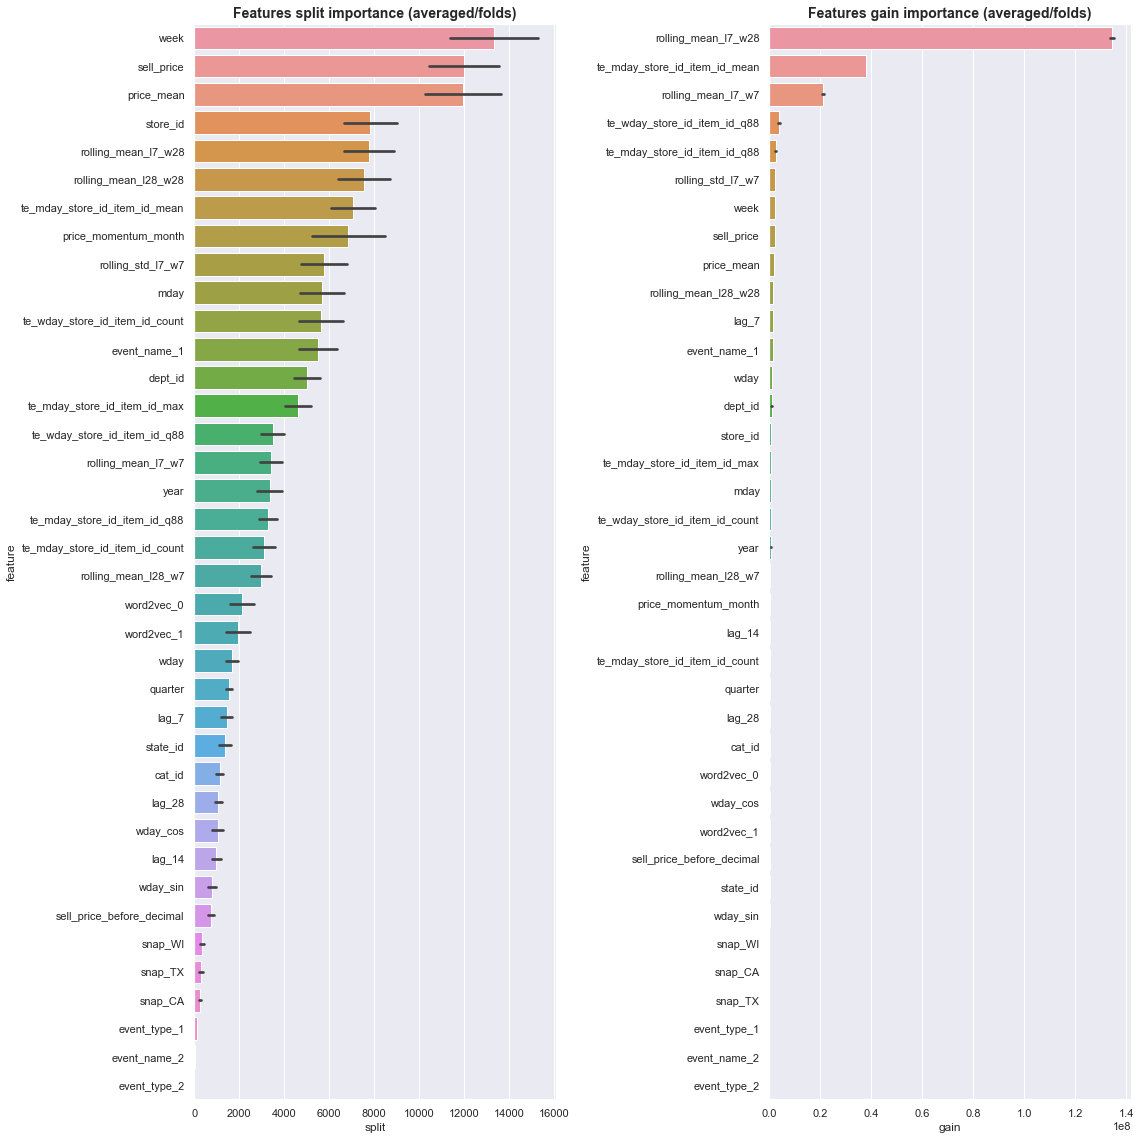

In [263]:
plot_feature_importance(fimp)

### Hyperparameter Tuning with Bayesian Optimization

In [327]:
def returnValidScore(learning_rate, num_leaves,
                     feature_fraction, bagging_fraction,
                     lambda_l1, lambda_l2,
                     min_data_in_leaf, min_child_weight,
                     tweedie_variance_power):
    
    train_cols = return_cols(df)
    gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed,
                num_leaves=num_leaves, learning_rate=learning_rate,
                bagging_fraction=bagging_fraction, feature_fraction=feature_fraction,
                lambda_l1=lambda_l1, lambda_l2=lambda_l2,
                min_data_in_leaf=min_data_in_leaf, min_child_weight=min_child_weight,
                tweedie_variance_power=tweedie_variance_power)
    models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(4)],
                                                                el, '', record=False, mock=False, verbose=0)
    del models, fimp, train_score; gc.collect()
    return -valid_score

In [331]:
def optimizeLgbParams(init_points=20, n_iteration=40):
    bounds = {'learning_rate':          (0.001, 0.3),
              'num_leaves':             (20,    2_048),
              'bagging_fraction' :      (0.0,   1),
              'feature_fraction' :      (0.0,   1),
              'min_child_weight':       (0.0,   1),
              'min_data_in_leaf':       (10,    4_096),
              'lambda_l1':              (0.0,   500),
              'lambda_l2':              (0.0,   500),
              'tweedie_variance_power': (1.0,   2.0)}
    
    optimizer = BayesianOptimization(f=returnValidScore, pbounds=bounds, random_state=seed)
    optimizer.maximize(init_points=init_points, n_iter=n_iteration)
    
    print('Best score:', -optimizer.max['target'])
    print('Best set of parameters:')
    print(optimizer.max['params'])
    
    return optimizer.max['params']

In [332]:
%%time
best_params = optimizeLgbParams()

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | min_ch... | min_da... | num_le... | tweedi... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.052    |  0.9985   |  0.7601   |  1.722    |  395.5    |  0.2582   |  0.7651   |  3.139e+0 |  836.7    |  1.173    |
|  2        | -2.064    |  0.4004   |  0.6796   |  316.4    |  308.5    |  0.1582   |  0.8454   |  1.883e+0 |  1.686e+0 |  1.856    |
|  3        | -2.043    |  0.7536   |  0.699    |  352.3    |  346.2    |  0.1385   |  0.7707   |  1.577e+0 |  1.944e+0 |  1.294    |
|  4        | -2.056    |  0.6698   |  0.3324   |  70.87    |  287.9    |  0.236    |  0.5115   |  2.799e+0 |  797.3    |  1.801    |
|  5        | -2.054    |  0.6517   |  0.3968   |  342.7    |  299.9    |  0.2764   |  0.2747   |  2.584e+0 |  1.314e+0 |  1.656    |
|  6        | -2.064    |  0.7623   |  0.7956   |  451.8    | 

KeyboardInterrupt: 

In [339]:
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed,
            num_leaves=633, learning_rate=0.02791, bagging_fraction=0.2273, feature_fraction=0.6926,
            lambda_l1=292.8, lambda_l2=282.5, min_data_in_leaf=500, min_child_weight=0.4017,
            tweedie_variance_power=1.077)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                            el, '40 iterations of BayesOpt', record=True, mock=False, verbose=200)

scheme (1/1): fold (1/2), Training until validation scores don't improve for 400 rounds
[200]	train_set's rmse: 2.15122	valid_set's rmse: 2.10319
[400]	train_set's rmse: 2.10922	valid_set's rmse: 2.09335
[600]	train_set's rmse: 2.08688	valid_set's rmse: 2.08825
[800]	train_set's rmse: 2.0692	valid_set's rmse: 2.08582
[1000]	train_set's rmse: 2.05442	valid_set's rmse: 2.08489
[1200]	train_set's rmse: 2.04281	valid_set's rmse: 2.08437
[1400]	train_set's rmse: 2.03136	valid_set's rmse: 2.08381
[1600]	train_set's rmse: 2.02178	valid_set's rmse: 2.08418
[1800]	train_set's rmse: 2.01282	valid_set's rmse: 2.08411
Early stopping, best iteration is:
[1422]	train_set's rmse: 2.03046	valid_set's rmse: 2.08341
(2/2)
Training until validation scores don't improve for 400 rounds
[200]	train_set's rmse: 2.14333	valid_set's rmse: 1.9933
[400]	train_set's rmse: 2.09978	valid_set's rmse: 1.98085
[600]	train_set's rmse: 2.07663	valid_set's rmse: 1.97556
[800]	train_set's rmse: 2.06018	valid_set's rmse: 1

In [364]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
264,40 iterations of BayesOpt,"[dept_id, store_id, cat_id, state_id, wday, ye...",2,0.505083,38,2.018056,2.02772


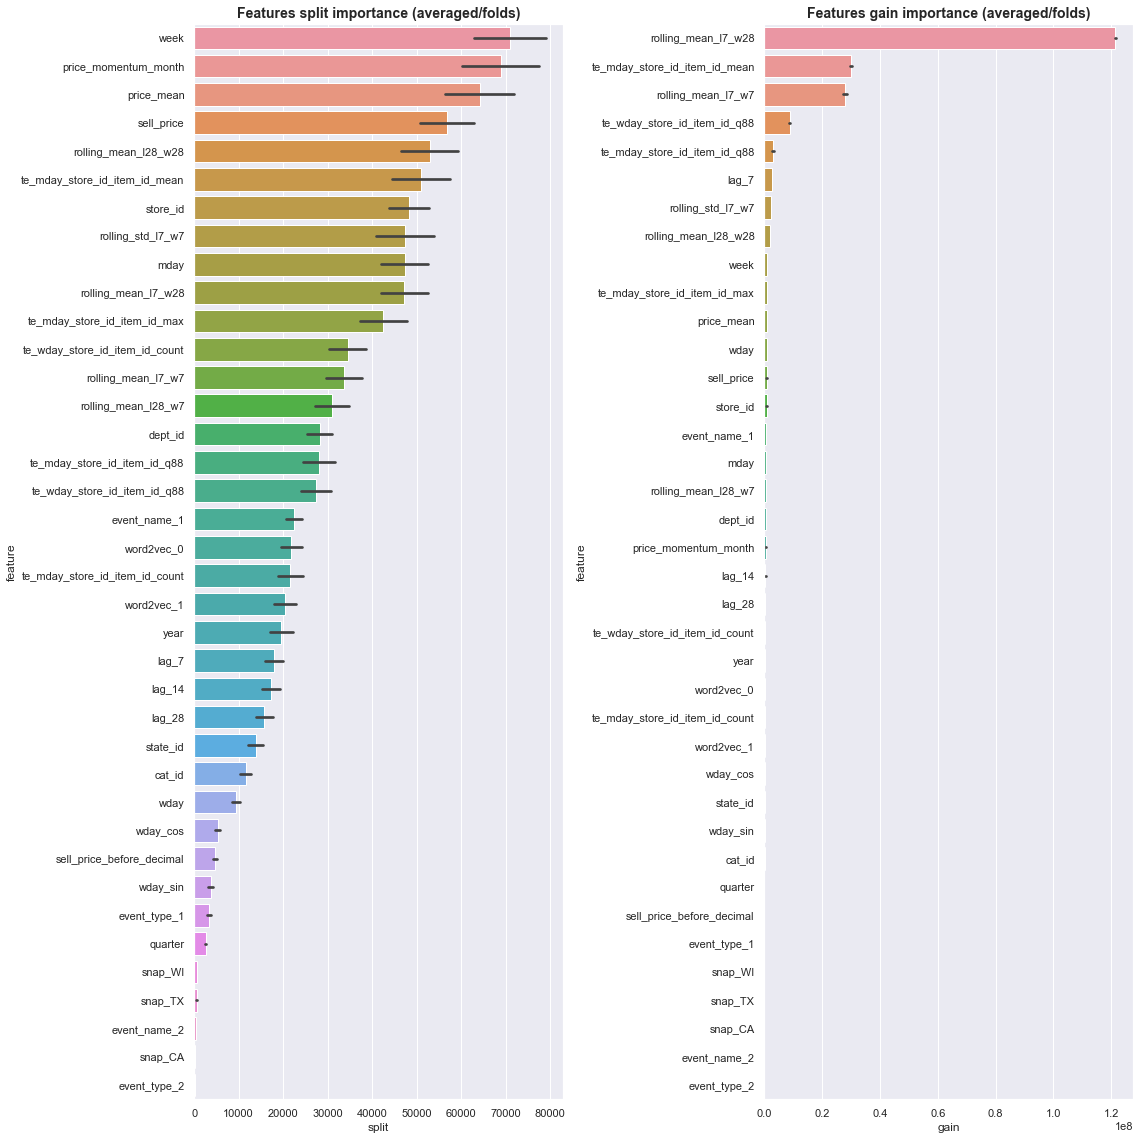

In [343]:
plot_feature_importance(fimp)

# CatBoost Regressor (RMSE)

In [414]:
class MyCatb:
    def __init__(self,
                 target_col, feature_cols, category_cols, seed,
                 loss='Tweedie', metric='RMSE', variance_power=1.077,
                 learning_rate=0.02791, num_leaves=633, max_depth=16,
                 subsample=0.2273, bagging_temperature=1.0, colsample_bylevel=0.6926,
                 min_data_in_leaf=500, l2_leaf_reg=282.5):
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.category_cols = category_cols
        self.metric = metric
        self.params = {'loss_function': f'{loss}:variance_power={variance_power}', 'eval_metric': metric,
                       'boosting_type': 'Plain', 'random_seed': seed, 'num_boost_round': 10_000, 'early_stopping_rounds': 400,
                       'use_best_model': True, 'grow_policy': 'Lossguide',#'SymmetricTree','Depthwise',
                       'nan_mode': 'Min', 'od_type': 'Iter', 'verbose': 200,
                       'learning_rate': learning_rate, 'max_depth': int(max_depth), 'num_leaves': int(num_leaves), 
                       'subsample': subsample, #bf
                       'bagging_temperature': bagging_temperature, #weight
                       'colsample_bylevel': colsample_bylevel, #ff
                       'min_data_in_leaf': int(min_data_in_leaf),
                       'l2_leaf_reg': l2_leaf_reg, #L2
                 }
    
    """printing function for each fold"""
    @staticmethod
    def _print(valid_scheme, fold_i):
        if fold_i == 0:
            print(f'fold ({fold_i+1}/{valid_scheme.n_splits})', end=', ')
        elif fold_i + 1 == valid_scheme.n_splits:
            print(f'({fold_i+1}/{valid_scheme.n_splits})')
        else:
            print(f'({fold_i+1}/{valid_scheme.n_splits})', end=', ')
    
    """feature importance collecting function"""
    def _fimp(self, model, scheme_i, fold_i):
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = self.feature_cols + self.category_cols
        fold_importance_df['importance'] = model.get_feature_importance()
        fold_importance_df['scheme'] = scheme_i + 1
        fold_importance_df['fold'] = fold_i + 1
        self.fimp = pd.concat([self.fimp, fold_importance_df], axis=0)
        del fold_importance_df; gc.collect()
    
    """returns list of models for test time and fimp_df"""
    def cross_validate(self, train_df: pd.DataFrame, cv: list, logger, what: str, record=True, verbose=200, mock=False):
        metric_tr = []; metric_cv = []; models = []; learning_curves = []
        self.fimp = pd.DataFrame()
        self.params['verbose'] = verbose
        
        for scheme_i, valid_scheme in enumerate(cv):
            
            """alter seed per valid_scheme"""
            print(f'scheme ({scheme_i+1}/{len(cv)})', end=': ')
            params = self.params.copy()
            params['random_seed'] = self.params['random_seed'] + scheme_i
            
            for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme._auto_split(train_df)):
            #for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme.split(train_df)):
                
                MyCatb._print(valid_scheme, fold_i)
                
                if mock:
                    continue
                
                train_idx = list(set(train_idx) - set(bad_zero_idx))
                
                d_train = cb.Pool(data=train_df[self.feature_cols + self.category_cols].loc[train_idx],
                                  label=train_df[self.target_col].loc[train_idx],
                                  cat_features=self.category_cols)
                d_valid = cb.Pool(data=train_df[self.feature_cols + self.category_cols].loc[valid_idx],
                                  label=train_df[self.target_col].loc[valid_idx],
                                  cat_features=self.category_cols)
                
                model = cb.CatBoostRegressor(**params)
                model.fit(d_train, eval_set=d_valid)
                models.append(model)
                
                metric_cv.append(model.best_score_['validation'][self.metric])
                
                MyCatb._fimp(self, model, scheme_i, fold_i)
                
                del d_train, d_valid, model
                gc.collect()
        
        if record:
            record_dict = {'description': what,
                           'features': self.feature_cols.copy() + self.category_cols.copy(),
                           'n_splits': cv[0].n_splits,
                           'R': len(self.feature_cols + self.category_cols),
                           'train_rmse': np.mean(metric_tr),
                           'valid_rmse': np.mean(metric_cv)}
            logger.record(record_dict)
            try:
                logger.export()
            except:
                print('Logger export failed')
        
        gc.collect()
        return models, self.fimp, np.mean(metric_tr), np.mean(metric_cv)

In [378]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyCatb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                            el, 'i264 CatBoost mock', record=True, mock=True, verbose=200)

scheme (1/1): fold (1/2), (2/2)


In [381]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
265,i264 CatBoost mock,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,NaN


In [398]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyCatb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                            el, 'i264 CatBoost', record=True, mock=False, verbose=200)

scheme (1/1): fold (1/2), 0:	learn: 3.9135793	test: 3.8743801	best: 3.8743801 (0)	total: 37.7s	remaining: 4d 8h 43m 55s
200:	learn: 3.7607158	test: 3.6943155	best: 3.6107378 (45)	total: 1h 6m 51s	remaining: 2d 6h 19m 43s
400:	learn: 3.7904567	test: 3.7183960	best: 3.6107378 (45)	total: 2h 16m 3s	remaining: 2d 6h 16m 44s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 3.610737796
bestIteration = 45

Shrink model to first 46 iterations.
(2/2)
0:	learn: 3.9066452	test: 3.8255172	best: 3.8255172 (0)	total: 1m 3s	remaining: 7d 8h 8m 2s
200:	learn: 3.7528991	test: 3.6360499	best: 3.5581455 (46)	total: 1h 6m 58s	remaining: 2d 6h 25m 24s
400:	learn: 3.7814214	test: 3.6588433	best: 3.5581455 (46)	total: 2h 15m 2s	remaining: 2d 5h 52m 45s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 3.558145516
bestIteration = 46

Shrink model to first 47 iterations.


In [400]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
266,i264 CatBoost,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,3.584442


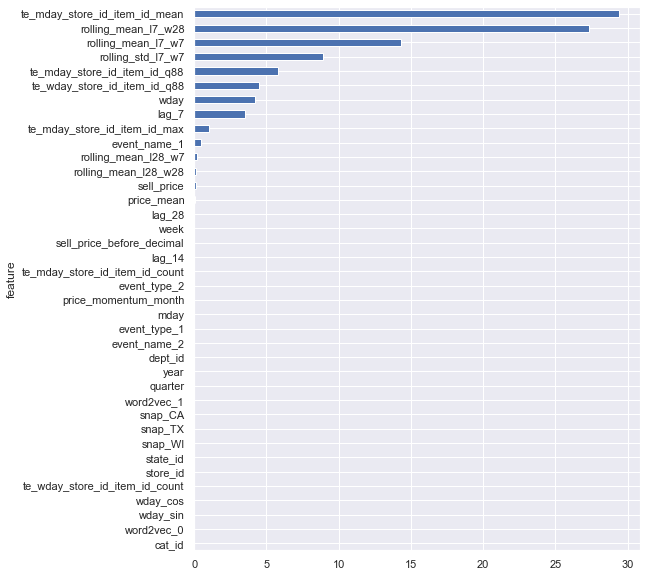

In [415]:
fimp.groupby('feature').importance.mean().sort_values(ascending=True).plot.barh(figsize=(8,10))

In [416]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyCatb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models, fimp, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                            el, 'i264 CatBoost, lossguide', record=True, mock=False, verbose=200)

scheme (1/1): fold (1/2), 0:	learn: 3.9135479	test: 3.8743475	best: 3.8743475 (0)	total: 23.1s	remaining: 2d 16h 14m 55s
200:	learn: 3.7855878	test: 3.7211558	best: 3.6126328 (43)	total: 38m 26s	remaining: 1d 7h 14m 11s
400:	learn: 3.8031077	test: 3.7336770	best: 3.6126328 (43)	total: 1h 16m 6s	remaining: 1d 6h 21m 54s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 3.612632845
bestIteration = 43

Shrink model to first 44 iterations.
(2/2)
0:	learn: 3.9067155	test: 3.8254724	best: 3.8254724 (0)	total: 17.7s	remaining: 2d 1h 10m 11s
200:	learn: 3.7775633	test: 3.6615203	best: 3.5600817 (44)	total: 39m 15s	remaining: 1d 7h 54m 13s
400:	learn: 3.7940853	test: 3.6708506	best: 3.5600817 (44)	total: 1h 16m 32s	remaining: 1d 6h 32m 11s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 3.560081656
bestIteration = 44

Shrink model to first 45 iterations.


In [417]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
267,"i264 CatBoost, lossguide","[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,3.586357


# XGBoost Regressor (RMSE)

In [267]:
class MyXgb:
    def __init__(self,
                 target_col, feature_cols, category_cols, seed,
                 objective='reg:tweedie', metric='rmse', tree_method='hist', tweedie_variance_power=1.077,
                 eta=0.02791, gamma=0, max_leaves=633, max_depth=0,
                 subsample=0.2273, colsample_bytree=0.6926,
                 min_child_weight=0.4017,
                 reg_lambda=282.5, reg_alpha=292.8):
        
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.category_cols = category_cols
        self.metric = metric
        self.params = {'seed': seed, 'tree_method': 'hist', #approx
                       'objective': objective,'eval_metric': metric, 'booster': 'gbtree', # 'dart': 'rate_drop': (0.0, 1.0),
                       #'missing': np.nan,
                       'grow_policy': 'lossguide',#'depthwise',
                       'eta': eta, 'gamma': gamma, 'max_depth': int(max_depth), 'max_leaves': max_leaves,
                       'subsample': subsample, 'colsample_bytree': colsample_bytree,
                       #'colsample_bynode': colsample_bynode, 'colsample_bylevel': colsample_bylevel,
                       'min_child_weight': min_child_weight,
                       'reg_lambda': reg_lambda, 'reg_alpha': reg_alpha,
                       
                       'tweedie_variance_power': tweedie_variance_power,
                      } 
        
    """printing function for each fold"""
    @staticmethod
    def _print(valid_scheme, fold_i):
        if fold_i == 0:
            print(f'fold ({fold_i+1}/{valid_scheme.n_splits})', end=', ')
        elif fold_i + 1 == valid_scheme.n_splits:
            print(f'({fold_i+1}/{valid_scheme.n_splits})')
        else:
            print(f'({fold_i+1}/{valid_scheme.n_splits})', end=', ')
    
    """returns list of models for test time and fimp_df"""
    def cross_validate(self, train_df: pd.DataFrame, cv: list, logger, what: str, record=True, verbose=200, mock=False):
        metric_tr = []; metric_cv = []; models = []; learning_curves = []
        self.fimp = pd.DataFrame()
        
        temp_data = train_df[self.feature_cols + self.category_cols + [self.target_col] + ['date']].copy()
        
        for _ in self.category_cols:
            temp_data[_] = temp_data[_].cat.codes
        temp_data[self.feature_cols] = temp_data[self.feature_cols].fillna(temp_data[self.feature_cols].astype(np.float64).mean())
        
        for scheme_i, valid_scheme in enumerate(cv):
            
            """alter seed per valid_scheme"""
            print(f'scheme ({scheme_i+1}/{len(cv)})', end=': ')
            params = self.params.copy()
            params['seed'] = self.params['seed'] + scheme_i
            train_df[f'xgb_oof_{int(params["seed"])}'] = np.nan
            
            for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme._auto_split(train_df)):
            #for fold_i, (train_idx, valid_idx) in enumerate(valid_scheme.split(train_df)):
                
                MyXgb._print(valid_scheme, fold_i)
                
                if mock:
                    print(f'train: {temp_data.date.loc[train_idx].min()} ~ {temp_data.date.loc[train_idx].max()}')
                    print(f'valid: {temp_data.date.loc[valid_idx].min()} ~ {temp_data.date.loc[valid_idx].max()}')
                    continue
                
                train_idx = list(set(train_idx) - set(bad_zero_idx))
                
                d_train = xgb.DMatrix(data=temp_data[self.feature_cols + self.category_cols].loc[train_idx],
                                      label=temp_data[self.target_col].loc[train_idx],
                                      feature_names=self.feature_cols + self.category_cols)
                d_valid = xgb.DMatrix(data=temp_data[self.feature_cols + self.category_cols].loc[valid_idx],
                                      label=temp_data[self.target_col].loc[valid_idx],
                                      feature_names=self.feature_cols + self.category_cols)
                
                learning_curve = {}
                model = xgb.train(params,
                                  d_train,
                                  evals=[(d_train, 'train'), (d_valid, 'valid')],
                                  num_boost_round=10_000,
                                  early_stopping_rounds=400,
                                  verbose_eval=verbose,#False
                                  evals_result=learning_curve)
                models.append(model)
                
                train_df.loc[valid_idx, f'xgb_oof_{int(params["seed"])}'] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)
                assert train_df.loc[valid_idx, f'xgb_oof_{int(params["seed"])}'].isna().sum() == 0
                
                #learning_curves.append(learning_curve)
                metric_cv.append(model.best_score)
                
                del d_train, d_valid, model
                gc.collect()
        
        del temp_data; gc.collect()
        
        if record:
            record_dict = {'description': what,
                           'features': self.feature_cols.copy() + self.category_cols.copy(),
                           'n_splits': cv[0].n_splits,
                           'R': len(self.feature_cols + self.category_cols),
                           'train_rmse': np.mean(metric_tr),
                           'valid_rmse': np.mean(metric_cv)}
            logger.record(record_dict)
            try:
                logger.export()
            except:
                print('Logger export failed')
        gc.collect()
        
        return models, np.mean(metric_tr), np.mean(metric_cv)

In [473]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyXgb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models, train_score, valid_score = gbm.cross_validate(df, [TimeSeriesSplitter(2)],
                                                      el, 'i264 XGBoost', record=True, mock=False, verbose=200)

scheme (1/1): fold (1/2), [12:24:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { missing } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.76900	valid-rmse:3.73074
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 400 rounds.
[200]	train-rmse:2.12085	valid-rmse:2.11114
[400]	train-rmse:2.06470	valid-rmse:2.10338
[600]	train-rmse:2.02867	valid-rmse:2.10023
[800]	train-rmse:2.00270	valid-rmse:2.09967
[1000]	train-rmse:1.98145	valid-rmse:2.09980
Stopping. Best iteration:
[689]	train-rmse:2.01622	valid-rmse:2.09886

(2/2)
[12:52:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
P

In [474]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
270,i264 XGBoost,"[wday, week, quarter, mday, snap_CA, snap_TX, ...",2,NaN,38,NaN,2.036928


# Blending

In [78]:
# LGB ()
# XGB (4 without bad_zero, diff seed ; 1 with bad_zero)
# DNN (4 with seed change)
# No CatBoost / LSTM / Prophet / ARIMA

In [87]:
cv = [eval('TimeSeriesSplitter(4)') for i in range(5)]

In [99]:
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed,
            num_leaves=633, learning_rate=0.02791, bagging_fraction=0.2273, feature_fraction=0.6926,
            lambda_l1=292.8, lambda_l2=282.5, min_data_in_leaf=500, min_child_weight=0.4017,
            tweedie_variance_power=1.077)
models_lgb, fimp, train_score, valid_score = gbm.cross_validate(df, cv,
                                                                el, '5 runs, LightGBM', record=True, mock=False, verbose=0)

scheme (1/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (2/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (3/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (4/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (5/5): fold (1/4), (2/4), (3/4), (4/4)


In [88]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyXgb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models_xgb, train_score, valid_score = gbm.cross_validate(df, cv,
                                                          el, '5 runs, XGBoost', record=True, mock=False, verbose=0)

scheme (1/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (2/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (3/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (4/5): fold (1/4), (2/4), (3/4), (4/4)
scheme (5/5): fold (1/4), (2/4), (3/4), (4/4)


In [101]:
oof_lgb_cols = []; oof_xgb_cols = []

for _ in df.columns:
    if 'lgb' in _:
        oof_lgb_cols.append(_)
    elif 'xgb' in _:
        oof_xgb_cols.append(_)

In [103]:
temp_lgb = df[oof_lgb_cols + ['sales', 'date']].copy()
temp_lgb['lgb_oof'] = temp_lgb[oof_lgb_cols].mean(axis=1)
mask_lgb = temp_lgb.lgb_oof_8982.notnull()

temp_lgb.head()

,lgb_oof_8982,lgb_oof_8983,lgb_oof_8984,lgb_oof_8985,lgb_oof_8986,sales,date,lgb_oof
0,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
1,NaN,NaN,NaN,NaN,NaN,2.0,2012-01-13,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,2012-01-13,NaN


In [104]:
np.sqrt(mean_squared_error(temp_lgb[mask_lgb].sales, temp_lgb[mask_lgb].lgb_oof_8982))

2.040059142354128

In [105]:
np.sqrt(mean_squared_error(temp_lgb[mask_lgb].sales, temp_lgb[mask_lgb].lgb_oof))

2.0377371668046735

In [106]:
temp_xgb = df[oof_xgb_cols + ['sales', 'date']].copy()
temp_xgb['xgb_oof'] = temp_xgb[oof_xgb_cols].mean(axis=1)
mask_xgb = temp_xgb.xgb_oof_8982.notnull()

temp_xgb.head()

,xgb_oof_8982,xgb_oof_8983,xgb_oof_8984,xgb_oof_8985,xgb_oof_8986,sales,date,xgb_oof
0,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
1,NaN,NaN,NaN,NaN,NaN,2.0,2012-01-13,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0,2012-01-13,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,2012-01-13,NaN


In [107]:
np.sqrt(mean_squared_error(temp_xgb[mask_xgb].sales, temp_xgb[mask_xgb].xgb_oof_8982))

2.0575821069166236

In [108]:
np.sqrt(mean_squared_error(temp_xgb[mask_xgb].sales, temp_xgb[mask_xgb].xgb_oof))

2.054269915904514

In [111]:
assert set(temp_lgb[mask_lgb].index) == set(temp_xgb[mask_xgb].index)
intersecting_idx = list(set(temp_lgb[mask_lgb].index).intersection(set(temp_xgb[mask_xgb].index)))

In [112]:
temp_lgb = temp_lgb.lgb_oof.loc[intersecting_idx]
temp_xgb = temp_xgb.xgb_oof.loc[intersecting_idx]

In [114]:
best_threshold = None
best_score     = 100
y_true         = df.sales.loc[intersecting_idx]

assert len(y_true) == len(temp_lgb) == len(temp_xgb)

In [116]:
for _ in np.linspace(0.00, 1.00, 101):
    y_pred = (_ * temp_lgb) + ((1 - _) * temp_xgb)
    score = np.sqrt(mean_squared_error(y_true, y_pred))
    
    if score < best_score:
        best_score = score
        best_threshold = _
    
    del score, _
    gc.collect()

print('best_lgb_threshold:', best_threshold)
print('best_score:', best_score)

best_lgb_threshold: 0.87
best_score: 2.0373790300418424


In [270]:
# With optimal threshold for blending, now obtain models with n_splits=2, ._auto_slpit()
# Without public dataset as train set

In [273]:
cv = [eval('TimeSeriesSplitter(2)') for i in range(5)]

In [276]:
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed,
            num_leaves=633, learning_rate=0.02791, bagging_fraction=0.2273, feature_fraction=0.6926,
            lambda_l1=292.8, lambda_l2=282.5, min_data_in_leaf=500, min_child_weight=0.4017,
            tweedie_variance_power=1.077)
models_lgb, fimp, train_score, valid_score = gbm.cross_validate(df, cv,
                                                                el, '5 runs, LightGBM, _auto_split', record=True, mock=False, verbose=0)

scheme (1/5): fold (1/2), (2/2)
scheme (2/5): fold (1/2), (2/2)
scheme (3/5): fold (1/2), (2/2)
scheme (4/5): fold (1/2), (2/2)
scheme (5/5): fold (1/2), (2/2)


In [277]:
num_cols, cat_cols = return_cols(df, separate_cat=True)
gbm = MyXgb(target_col='sales', feature_cols=num_cols, category_cols=cat_cols, seed=seed)
models_xgb, train_score, valid_score = gbm.cross_validate(df, cv,
                                                          el, '5 runs, XGBoost, _auto_split', record=True, mock=False, verbose=0)

scheme (1/5): fold (1/2), (2/2)
scheme (2/5): fold (1/2), (2/2)
scheme (3/5): fold (1/2), (2/2)
scheme (4/5): fold (1/2), (2/2)
scheme (5/5): fold (1/2), (2/2)


In [352]:
_ = [_ for _ in df.columns if 'lgb' in _]
df['lgb_oof'] = df[_].mean(axis=1)
_ = [_ for _ in df.columns if 'xgb' in _]
df['xgb_oof'] = df[_].mean(axis=1)

df['oof'] = (best_threshold * df.lgb_oof) + ((1 - best_threshold) * df.xgb_oof)

In [356]:
mask = df.lgb_oof.notnull()
assert df[mask].oof.isna().sum() == 0
valid_rmse = np.sqrt(mean_squared_error(df.sales[mask], df.oof[mask]))
valid_rmse

2.024439346198441

In [364]:
el.return_log().tail(1)

,description,features,n_splits,public,R,train_rmse,valid_rmse
274,0.87*lgb + (0.13)*xgb,NaN,NaN,0.506521,NaN,NaN,2.024439


In [402]:
# WITH public dataset as train set

In [412]:
cv = [eval('TimeSeriesSplitter(3)') for i in range(5)]

In [414]:
train_cols = return_cols(df)
gbm = MyLgb(target_col='sales', feature_cols=train_cols, seed=seed,
            num_leaves=633, learning_rate=0.02791, bagging_fraction=0.2273, feature_fraction=0.6926,
            lambda_l1=292.8, lambda_l2=282.5, min_data_in_leaf=500, min_child_weight=0.4017,
            tweedie_variance_power=1.077)
models_lgb_w_pub, fimp, train_score, valid_score = gbm.cross_validate(df, cv,
                                                                      el, '5 runs, LightGBM, _auto_split w/ public data', record=True,
                                                                      mock=False, verbose=0)

scheme (1/5): fold (1/3), (2/3), (3/3)
scheme (2/5): fold (1/3), (2/3), (3/3)
scheme (3/5): fold (1/3), (2/3), (3/3)
scheme (4/5): fold (1/3), (2/3), (3/3)
scheme (5/5): fold (1/3), (2/3), (3/3)


# Recursive Prediction

In [278]:
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913 (train)
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

## Single Model

In [424]:
def recursive_prediction(df, test_df_start_date, fday, models, alpha=1.02):
    
    if isinstance(models[0], xgb.core.Booster):
        test_df = df.copy()
        for _ in cat_cols:
            #print(_)
            test_df[_] = test_df[_].cat.codes
        test_df[num_cols + cat_cols] = test_df[num_cols + cat_cols].fillna(test_df[num_cols + cat_cols].astype(np.float64).mean())
        assert test_df[num_cols + cat_cols].isna().sum().sum() == 0
        assert test_df[num_cols + cat_cols].select_dtypes('category').shape[1] == 0
        assert test_df[num_cols + cat_cols].select_dtypes('object').shape[1] == 0
        test_df = test_df[test_df.date >= test_df_start_date]
        # return test_df
    else:
        test_df = df[df.date >= test_df_start_date].copy()
    gc.collect()
    
    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        #print(str(day).split(' ')[0])
        print('.', end='')

        test_df_temp = test_df[(test_df.date >= day - timedelta(days=max_lags)) & (test_df.date <= day)]
        create_fea(test_df_temp)
        test_df_temp = test_df_temp.loc[test_df_temp.date == day]
        assert test_df_temp['lag_7'].isna().sum().sum() == 0, print(test_df_temp[train_cols].isna().sum())

        temp = np.zeros(test_df[test_df.date == day].shape[0])
        for _ in models:
            if isinstance(_, lgb.basic.Booster):
                test_df_temp['year'] = test_df_temp.year.astype('category')
                temp += (alpha * _.predict(test_df_temp[train_cols], num_iteration=_.best_iteration)) / len(models)
            elif isinstance(_, xgb.core.Booster):
                d_temp = xgb.DMatrix(test_df_temp[num_cols + cat_cols])
                temp += (alpha * _.predict(d_temp, ntree_limit=_.best_ntree_limit)) / len(models)
                del d_temp
        test_df.loc[test_df.date == day, "sales"] = temp
        
        del temp; gc.collect()
        assert test_df.loc[test_df.date == day].sales.isna().sum() == 0, print('recursive imputation not done')
    
    return test_df

In [284]:
# make sure train_cols is defined for LGB prediction
# make sure num_cols and cat_cols is defined for XGB prediction

In [285]:
%%time
test_df_lgb = recursive_prediction(df,
                                   test_df_start_date='2016-02-28', fday=datetime(2016,4,25),
                                   models=models_lgb, alpha=1.02)

............................Wall time: 50min 29s


In [286]:
test_df_lgb.loc[~(test_df_lgb.type == 'private'), 'id'] = test_df_lgb.loc[~(test_df_lgb.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

In [293]:
%%time
test_df_xgb = recursive_prediction(df,
                                   test_df_start_date='2016-02-28', fday=datetime(2016,4,25),
                                   models=models_xgb, alpha=1.02)

............................Wall time: 46min 13s


In [294]:
test_df_xgb.loc[~(test_df_xgb.type == 'private'), 'id'] = test_df_xgb.loc[~(test_df_xgb.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

In [314]:
assert (test_df_lgb.index == test_df_xgb.index).sum() == test_df_lgb.shape[0] == test_df_xgb.shape[0]
test_df = test_df_lgb.copy()
test_df['sales'] *= best_threshold #0.87
test_df['sales'] += (1 - best_threshold) * test_df_xgb.sales

In [315]:
submission = make_submission(test_df, pd.read_csv('data/sample_submission.csv'), 'public')

no negative values in forecast


In [316]:
submission.to_csv('submission.csv', index=False)

In [374]:
# Private Prediction, without public training data

In [385]:
%%time
test_df_lgb = recursive_prediction(df,
                                   test_df_start_date='2016-03-27', fday=datetime(2016,5,23),
                                   models=models_lgb, alpha=1.00)

test_df_lgb.loc[~(test_df_lgb.type == 'private'), 'id'] = test_df_lgb.loc[~(test_df_lgb.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

............................Wall time: 51min 15s


In [386]:
%%time
test_df_xgb = recursive_prediction(df,
                                   test_df_start_date='2016-03-27', fday=datetime(2016,5,23),
                                   models=models_xgb, alpha=1.00)

test_df_xgb.loc[~(test_df_xgb.type == 'private'), 'id'] = test_df_xgb.loc[~(test_df_xgb.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

............................Wall time: 46min 18s


In [400]:
test_df_lgb.to_csv('test_df_lgb_i272_private_predicted.csv')
test_df_xgb.to_csv('test_df_xgb_i272_private_predicted.csv')

In [452]:
# Private Prediction, with public training data

In [425]:
%%time
test_df_lgb = recursive_prediction(df,
                                   test_df_start_date='2016-03-27', fday=datetime(2016,5,23),
                                   models=models_lgb_w_pub, alpha=1.02)

test_df_lgb.loc[~(test_df_lgb.type == 'private'), 'id'] = test_df_lgb.loc[~(test_df_lgb.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

............................Wall time: 53min 16s


In [445]:
test_df_lgb.to_csv('i275_test_df_lgb.csv')

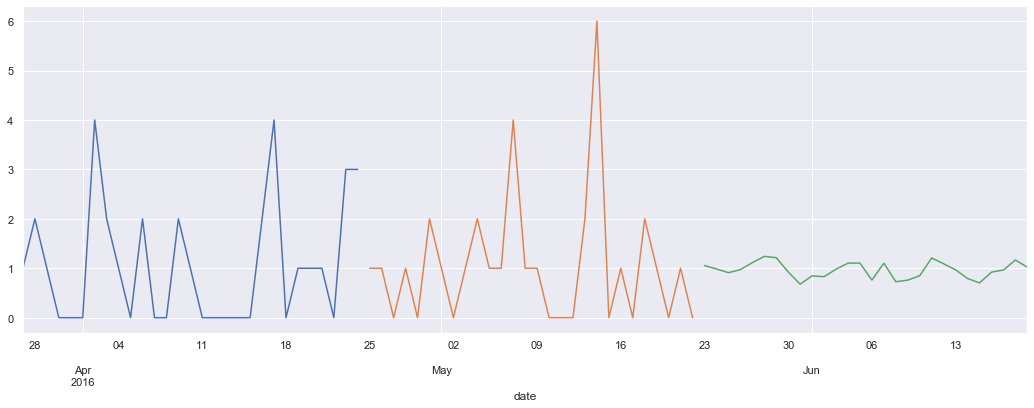

In [434]:
for _ in test_df_lgb.type.unique():
    test_df_lgb[(test_df_lgb.store_id == 'CA_3') &
                (test_df_lgb.item_id == 'HOBBIES_1_001') &
                (test_df_lgb.type == _)].set_index('date').sales.plot(figsize=(18,6))

In [533]:
submission = make_submission(test_df_lgb, pd.read_csv('data/sample_submission.csv'), 'private')

no negative values in forecast


In [538]:
submission.to_csv('submission.csv', index=False)

## Multi-Model by Store_id

In [143]:
def recursive_by_store(df, test_df_start_date, fday, info, train_cols, alpha = 1.02):
    train_cols = train_cols.copy()
    for _ in ['store_id', 'state_id']:
        if _ in train_cols:
            train_cols.remove(_)
    
    test_df = df[df.date >= test_df_start_date].copy()
    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        #print(str(day).split(' ')[0])
        print(tdelta, end=' - ')
        print(str(day).split(' ')[0], end=': ')

        test_df_day = test_df[(test_df.date >= day - timedelta(days=max_lags)) & (test_df.date <= day)].copy()
        create_fea(test_df_day)
        test_df_day = test_df_day.loc[test_df_day.date == day]
        assert test_df_day[['lag_7', 'lag_28',
                            'rolling_mean_l7_w7', 'rolling_mean_l28_w7', 'rolling_mean_l7_w28', 'rolling_mean_l28_w28',
                            'rolling_std_l7_w7',]].isna().sum().sum() == 0

        store_ids = df.store_id.unique()
        for store_id in store_ids:
            #store_id = int(store_id)

            if store_id != store_ids[-1]:
                print(store_id, end=', ')
            else:
                print(store_id)
            
            test_df_day_store = test_df_day[test_df_day.store_id == store_id]
            pred = np.zeros(test_df_day_store.shape[0])
            pred_idx = test_df_day_store.index

            models = info[info.store_id == store_id].models.values[0]
            for model in models:
                pred += (alpha * model.predict(test_df_day_store[train_cols], num_iteration=model.best_iteration)) / len(models)
            test_df.loc[pred_idx, "sales"] = pred
            assert test_df.loc[pred_idx].sales.isna().sum() == 0, print('recursive imputation not done')
        del test_df_day, test_df_day_store, pred, pred_idx, models
        gc.collect()
    
    return test_df

In [146]:
%%time
test_df = recursive_by_store(df, '2016-02-28', datetime(2016,4,25),
                             info, train_cols, alpha=1.02)

0 - 2016-04-25: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
1 - 2016-04-26: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
2 - 2016-04-27: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
3 - 2016-04-28: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
4 - 2016-04-29: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
5 - 2016-04-30: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
6 - 2016-05-01: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
7 - 2016-05-02: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
8 - 2016-05-03: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
9 - 2016-05-04: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
10 - 2016-05-05: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
11 - 2016-05-06: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
12 - 2016-05-07: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3
13 - 2016-05-08: CA_1,

In [147]:
test_df.loc[~(test_df.type == 'private'), 'id'] = test_df.loc[~(test_df.type == 'private')].id.apply(
    lambda x: '_'.join(return_list(x.split('_')))
)

In [148]:
submission = make_submission(test_df, pd.read_csv('data/sample_submission.csv'), 'public')

no negative values in forecast


# Normal Prediction

In [788]:
#test_df = create_dt(is_train=False)
#test_df.shape
#create_fea(test_df)

In [403]:
def make_submission(df, feature_cols, models, submission, n_splits, coefficient):
    test_df = df[(df['date'] > '2016-04-24')]
    
    y_test = np.zeros(test_df.shape[0])
    for model in models:
        y_test += model.predict(test_df[feature_cols], num_iteration=model.best_iteration)
    y_test = y_test * (coefficient / n_splits)
    
    preds = test_df[["id", "date", "sales"]].assign(sales=y_test)
    preds = preds.pivot(index="id", columns="date", values="sales").reset_index()
    preds.columns = ["id"] + ["F" + str(d + 1) for d in range(28)]

    evals = submission[submission["id"].str.endswith("evaluation")]
    vals = submission[["id"]].merge(preds, how="inner", on="id")
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])
    
    neg_checker(final, inplace=True)
    
    return final

In [405]:
test_df = test_df[test_df['date'] > '2016-04-24']

In [406]:
submission = pd.read_csv(f"data/sample_submission.csv")
submission = make_submission(test_df, train_cols, models, submission, 2, 1.0)

no negative values in forecast


In [210]:
#submission.to_csv('submission.csv', index=False)

# Public LB and CV-LB Scatter Plot

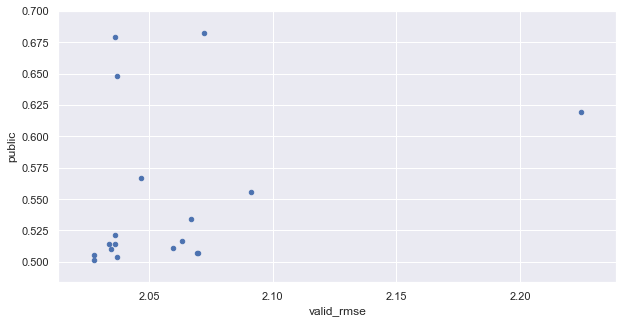

In [449]:
el.return_log()[el.return_log().n_splits == 2].plot.scatter(x='valid_rmse', y='public', figsize=(10,5))

In [527]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [528]:
def get_lb_rank(score):
    """
    Get rank on public LB as of 2020-05-31 23:59:59
    """
    df_lb = pd.read_csv("data/m5-forecasting-accuracy-publicleaderboard-rank.csv")
    
    return (df_lb.Score <= score).sum() + 1

In [529]:
def create_public_submission(submission):
    submission = submission[submission.id.str.contains("validation")]

    df_sample_submission = pd.read_csv("data/sample_submission.csv")
    df_sample_submission["order"] = range(df_sample_submission.shape[0])
    submission = submission.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1)
    submission.rename(columns = {
        "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
        "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
        "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
        "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
    }, inplace = True)

    df_train_full = pd.read_csv("data/sales_train_evaluation.csv")
    df_train = df_train_full.iloc[:, :-28]
    df_valid = df_train_full.iloc[:, -28:]

    evaluator = WRMSSEEvaluator(df_train, df_valid, pd.read_csv("data/calendar.csv"), pd.read_csv("data/sell_prices.csv"))
    del df_sample_submission, df_train_full, df_train, df_valid
    gc.collect()
    return submission, evaluator

In [530]:
submission, evaluator = create_public_submission(submission)

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


In [322]:
groups, scores = evaluator.score(submission)
score_public_lb = np.mean(scores)
print(f"Public LB Score: {round(score_public_lb, 5)}")
print(f"Public LB Rank: {get_lb_rank(score_public_lb)}")

Public LB Score: 0.50652
Public LB Rank: 1820


In [330]:
l = el.return_log()
l.loc[274, 'valid_rmse'] = np.nan
el.diff_check(l)
#el.set_self(l)

Updated value @ [#274, 'valid_rmse']: 2.0373790300418424 -> nan


## Visualization

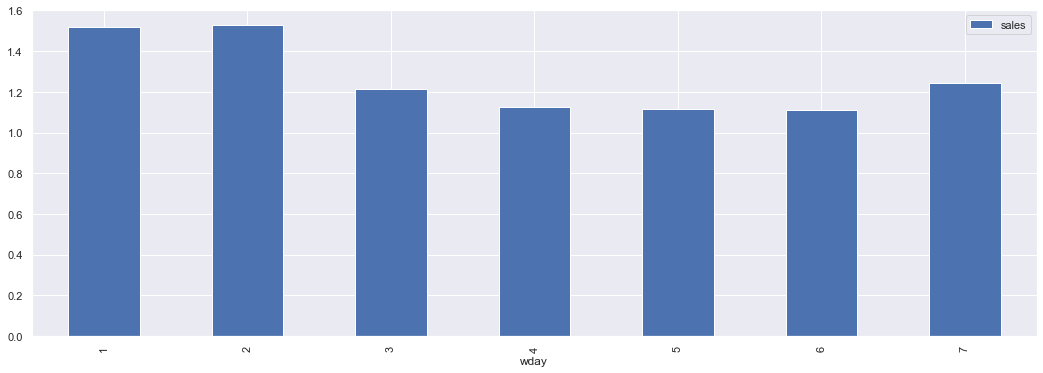

In [620]:
df[['wday', 'sales']].loc[mask].groupby('wday').mean().plot.bar(figsize=(18,6))

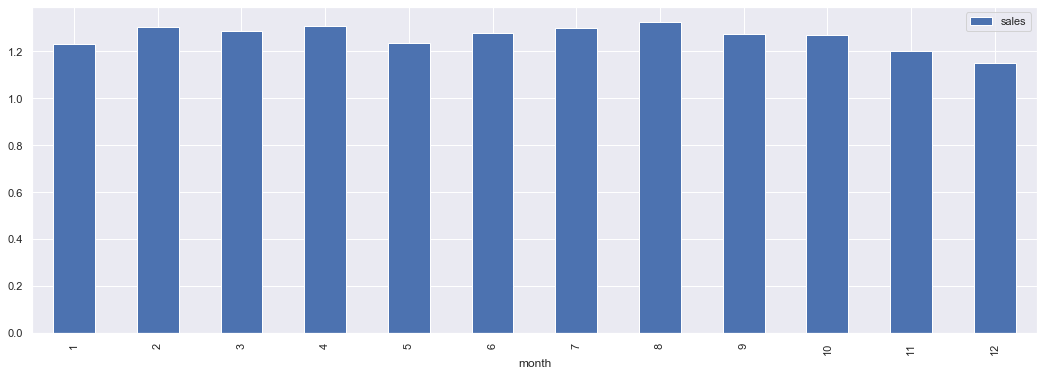

In [353]:
df[['month', 'sales']].loc[mask].groupby('month').mean().plot.bar(figsize=(18,6))

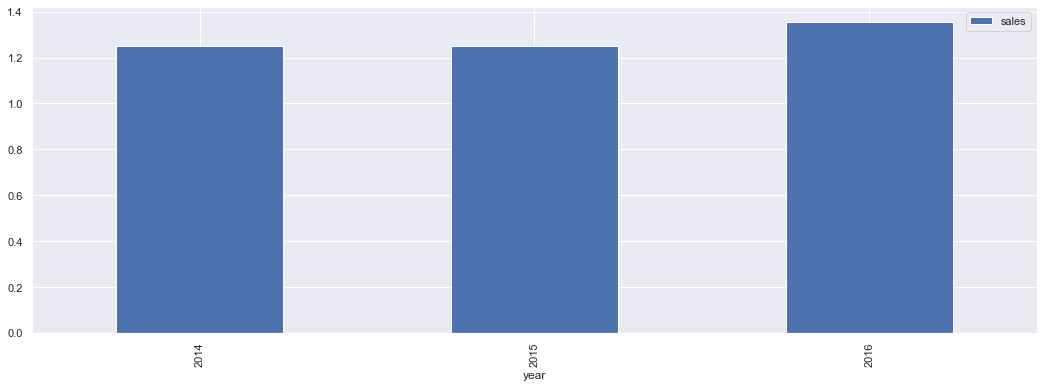

In [354]:
df[['year', 'sales']].loc[mask].groupby('year').mean().plot.bar(figsize=(18,6))

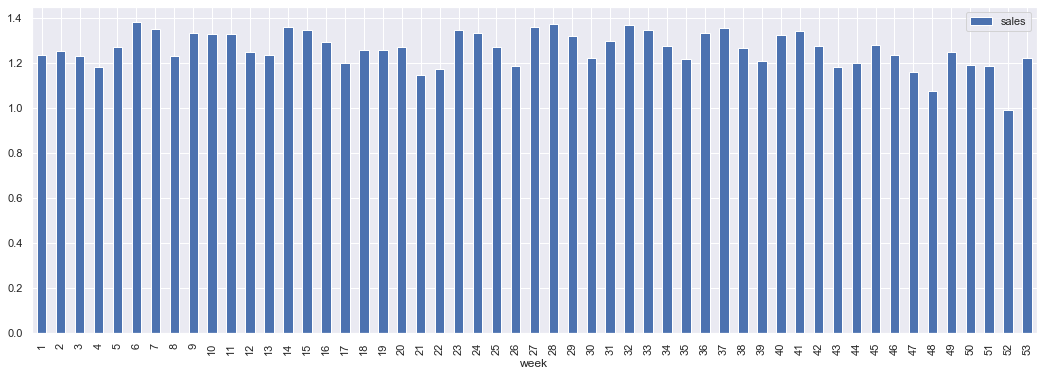

In [351]:
df[['week', 'sales']].loc[mask].groupby('week').mean().plot.bar(figsize=(18,6))

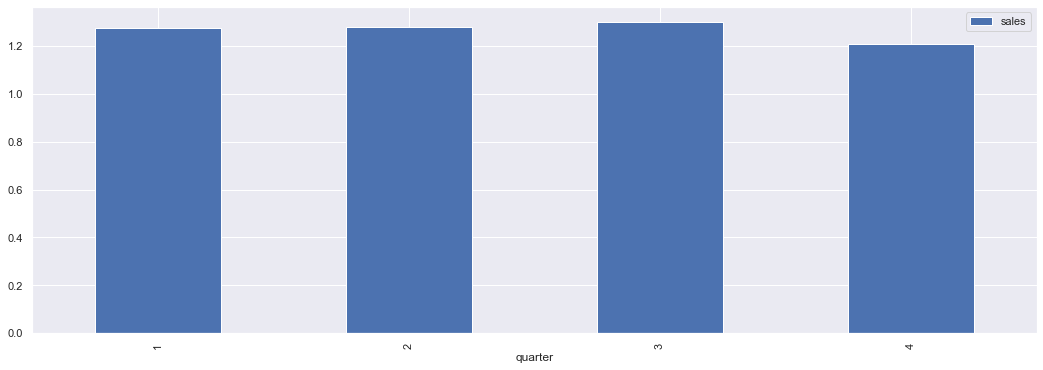

In [355]:
df[['quarter', 'sales']].loc[mask].groupby('quarter').mean().plot.bar(figsize=(18,6))

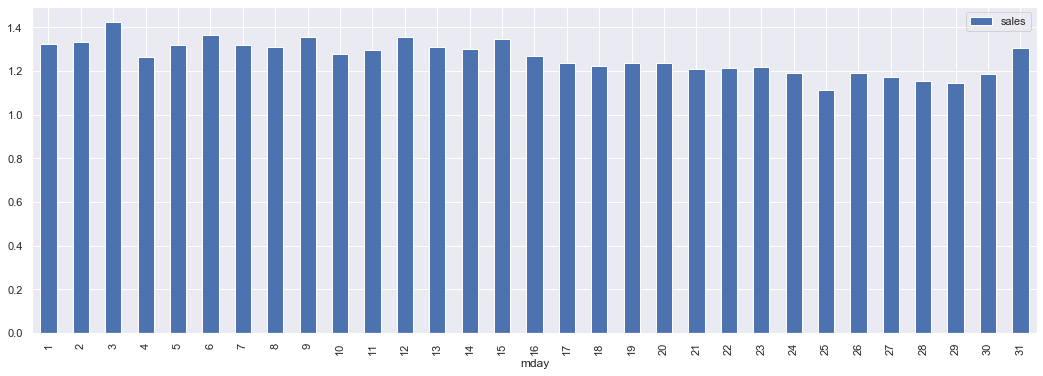

In [356]:
df[['mday', 'sales']].loc[mask].groupby('mday').mean().plot.bar(figsize=(18,6))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


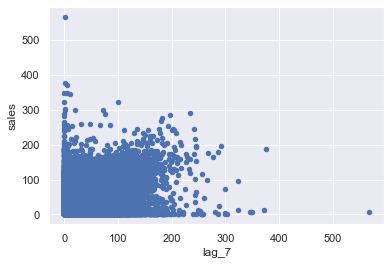

In [343]:
df[['lag_7', 'sales']].loc[mask].plot.scatter(x='lag_7', y='sales')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


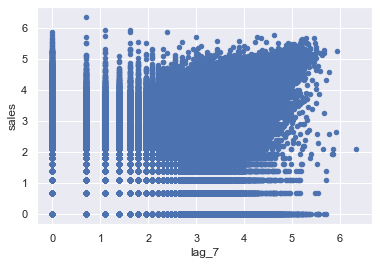

In [344]:
df[['lag_7', 'sales']].loc[mask].apply(np.log1p).plot.scatter(x='lag_7', y='sales')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


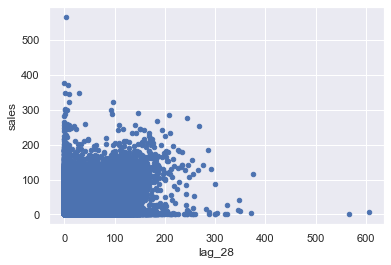

In [345]:
df[['lag_28', 'sales']].loc[mask].plot.scatter(x='lag_28', y='sales')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


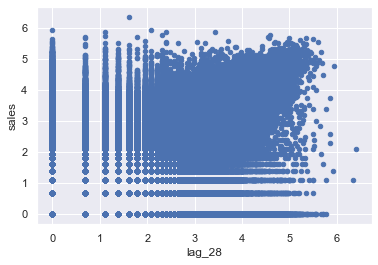

In [349]:
df[['lag_28', 'sales']].loc[mask].apply(np.log1p).plot.scatter(x='lag_28', y='sales')

4.0

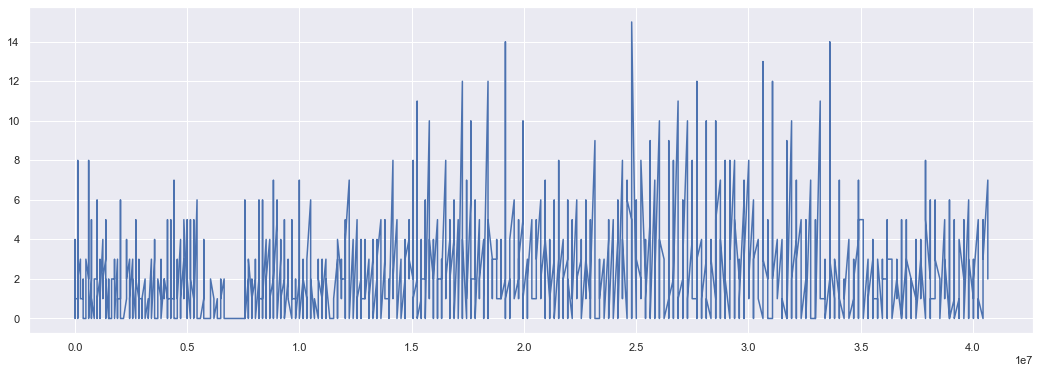

In [210]:
df[(df.item_id == 3) & (df.store_id == 0)].sales.plot(figsize=(18,6))
df[(df.item_id == 3) & (df.store_id == 0)].sales.quantile(0.88)

2.0

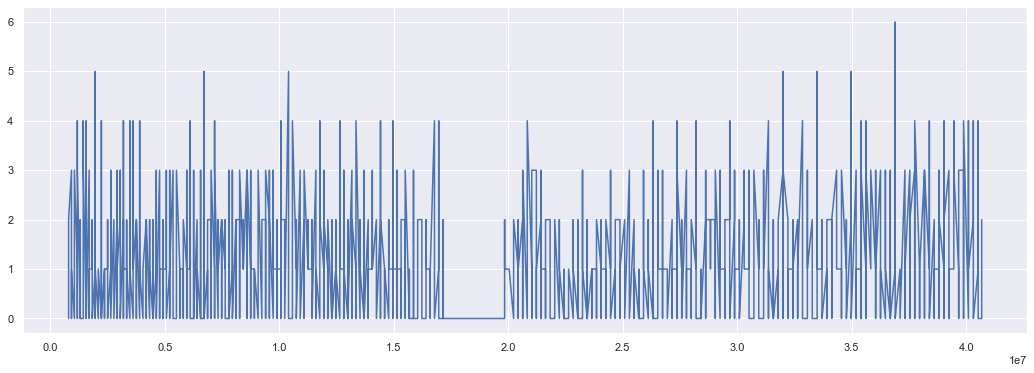

In [209]:
df[(df.item_id == 62) & (df.store_id == 4)].sales.plot(figsize=(18,6))
df[(df.item_id == 62) & (df.store_id == 4)].sales.quantile(0.88)

2.0

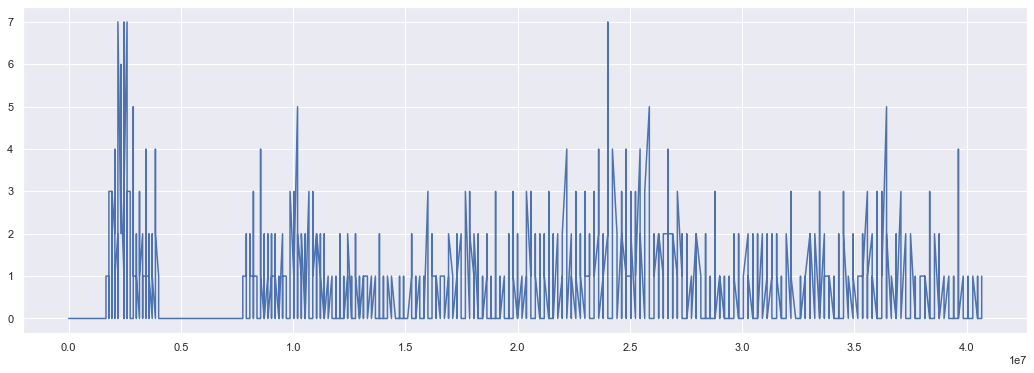

In [208]:
df[(df.item_id == 20) & (df.store_id == 2)].sales.plot(figsize=(18,6))
df[(df.item_id == 20) & (df.store_id == 2)].sales.quantile(0.88)

5.0

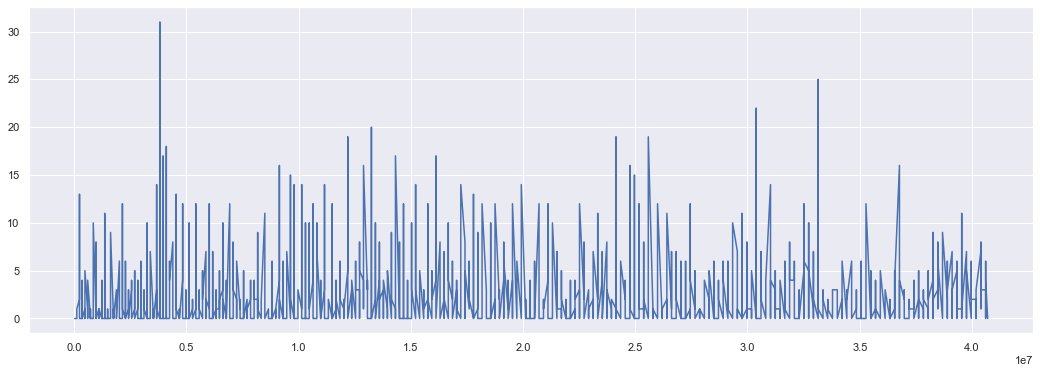

In [211]:
df[(df.item_id == 42) & (df.store_id == 8)].sales.plot(figsize=(18,6))
df[(df.item_id == 42) & (df.store_id == 8)].sales.quantile(0.88)

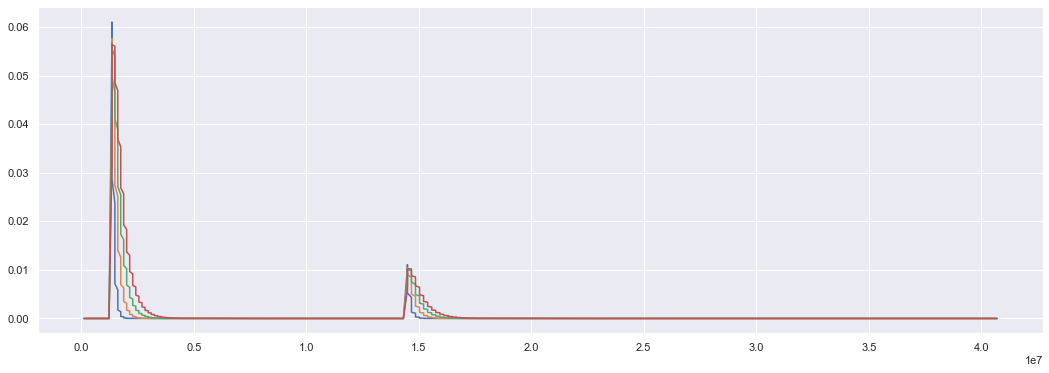

In [241]:
for _ in [5, 10, 15, 20]:
    df[(df.item_id == 42) & (df.store_id == 8)].sell_price.ewm(span=_, min_periods=1).std().plot(figsize=(18,6))

4185

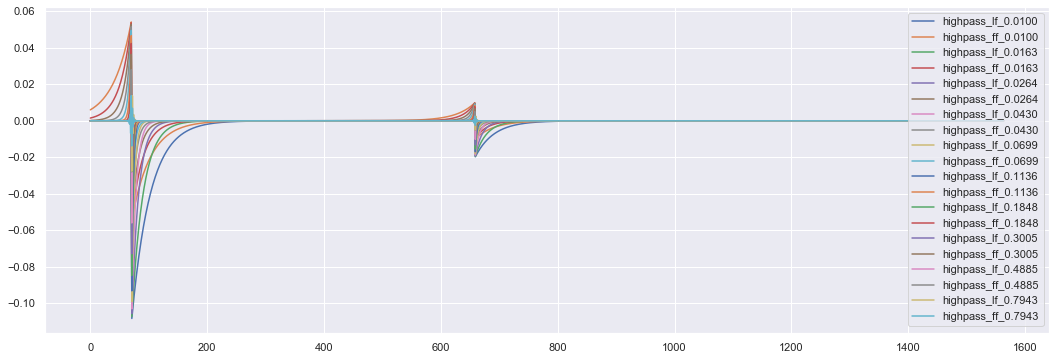

In [256]:
high_pass = pd.DataFrame()
x = df[(df.item_id == 42) & (df.store_id == 8)].sell_price.values
for _ in np.logspace(-2, -0.1, 10):
    b, a = signal.butter(1, Wn=_, btype='high')
    zi = signal.lfilter_zi(b, a)
    high_pass['highpass_lf_' + str('%.4f' %_)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
    high_pass['highpass_ff_' + str('%.4f' %_)] = signal.filtfilt(b, a, x)

high_pass.plot(figsize=(18,6))
del high_pass, x
gc.collect()

6563

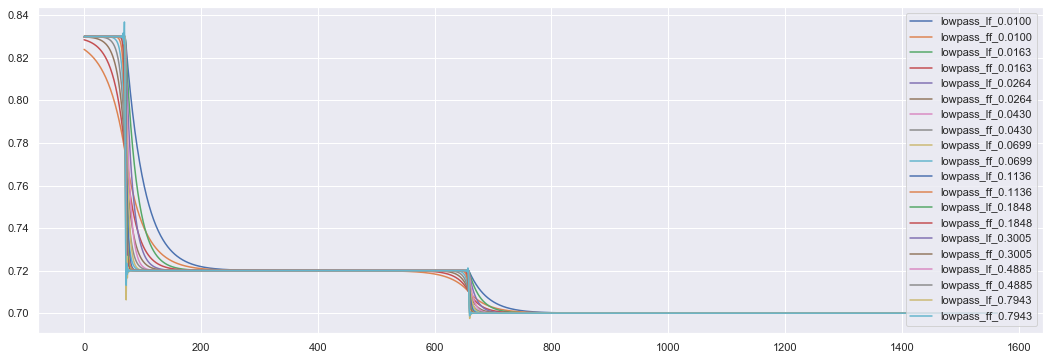

In [257]:
low_pass = pd.DataFrame()
x = df[(df.item_id == 42) & (df.store_id == 8)].sell_price.values
for _ in np.logspace(-2, -0.1, 10):
    b, a = signal.butter(1, Wn=_, btype='low')
    zi = signal.lfilter_zi(b, a)
    low_pass['lowpass_lf_' + str('%.4f' %_)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
    low_pass['lowpass_ff_' + str('%.4f' %_)] = signal.filtfilt(b, a, x)

low_pass.plot(figsize=(18,6))
del low_pass, x
gc.collect()

## Consecutive-Zero Detection

In [281]:
is_zero = df[(df.item_id == 'HOBBIES_1_115') & (df.store_id == 'CA_1')].sales
is_zero = np.where(is_zero == 0, 1, 0)
is_zero = pd.Series(is_zero)

In [282]:
is_zero

0       0
1       0
2       1
3       0
4       1
       ..
1236    0
1237    0
1238    0
1239    0
1240    0
Length: 1241, dtype: int32

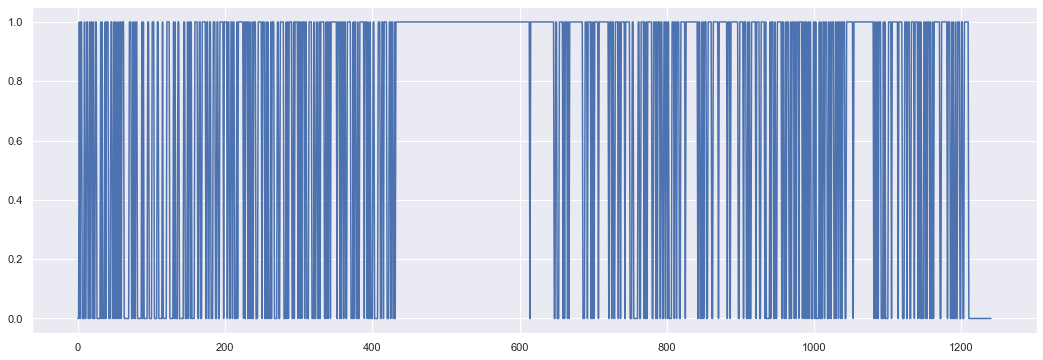

In [283]:
is_zero.plot(figsize=(18,6))

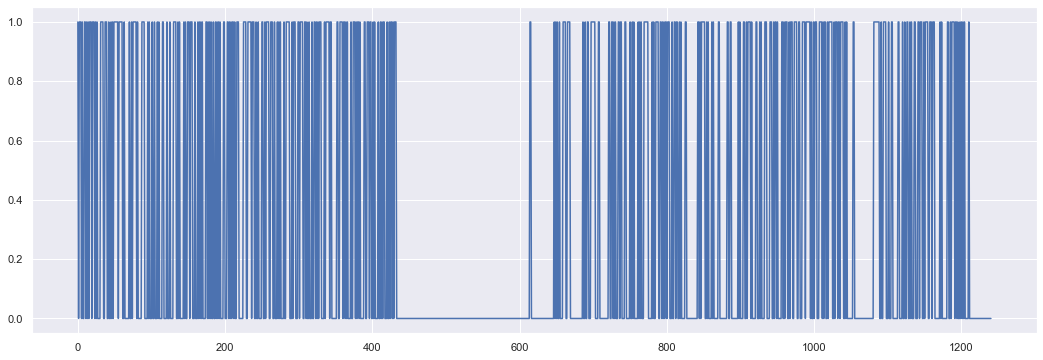

In [284]:
transitions = (is_zero != is_zero.shift(1))
transitions.astype(int).plot(figsize=(18,6))

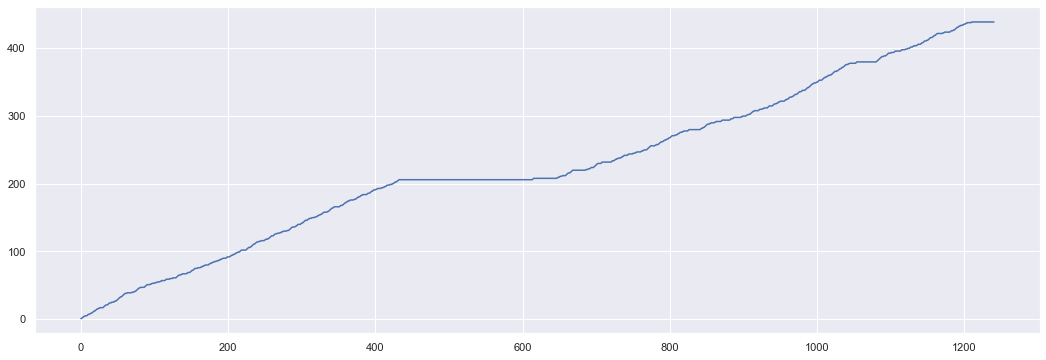

In [285]:
all_sequence_ids = transitions.cumsum()
all_sequence_ids.plot(figsize=(18,6))

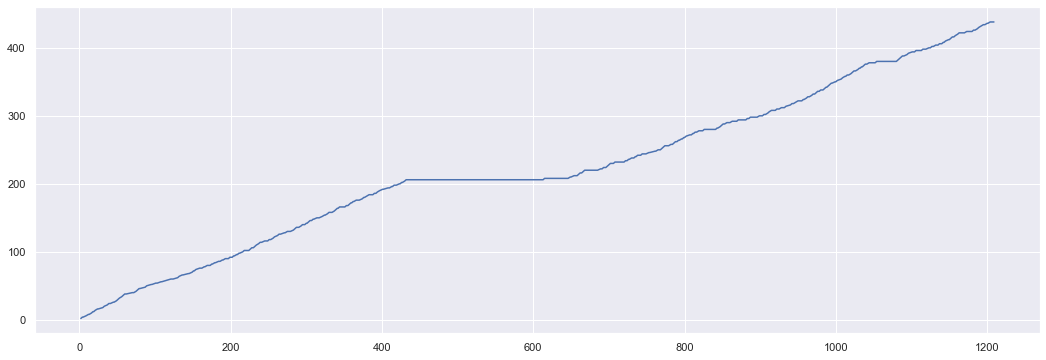

In [286]:
ids = all_sequence_ids[is_zero.astype(bool)].rename("ids")
ids.plot(figsize=(18,6))

In [287]:
min_interval = 31*2
is_bad = ids.map(ids.value_counts()) >= min_interval

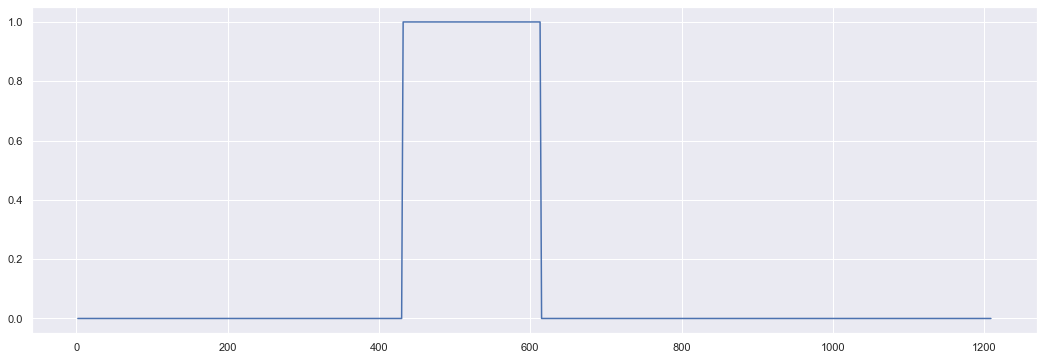

In [288]:
is_bad.astype(int).plot(figsize=(18,6))

In [290]:
ids.map(ids.value_counts()) >= min_interval

2       False
4       False
5       False
9       False
12      False
        ...  
1205    False
1206    False
1207    False
1208    False
1209    False
Name: ids, Length: 822, dtype: bool